select subject session FOV

In [1]:
#%% load data
import os
import BCI_analysis
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy.io import savemat
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.stats import zscore
import shutil
import matplotlib.pyplot as plt

import suite2p
BinaryFile = suite2p.io.BinaryFile

use_scalar_f0 = False
recalculate_f0 = False
remove_PMT_trips = True
remove_masking_flash = False
sessionwise_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba'
s2p_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim'
raw_scanimage_dir = '/home/jupyter/bucket/Data/Calcium_imaging/raw/Bergamo-2P-Photostim'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/'

#next_session_dir = '/home/jupyter/bucket/Data/Calcium_imaging/next_session'

maximum_decrease_in_f0 = .25 # if decreases above this amount will be thrown out
ignore_rundown = True
step_back = 60
step_forward = 300


subject = 'BCI_66'
fov = 'FOV_01'
subject = 'BCI_68'
fov = 'FOV_01'

use_red_channel = False
load_neuropil= True
load_mean_FOV = False
next_session_dir = '/home/jupyter/bucket/Data/Calcium_imaging/next_session/{}-{}/'.format(subject, fov)
files = os.listdir(os.path.join(sessionwise_base_dir,subject))
data_dict = {}
sessions = []
stat = np.load(os.path.join(s2p_base_dir,subject,fov,'stat.npy'),allow_pickle=True).tolist()
stat_rest = np.load(os.path.join(s2p_base_dir,subject,fov,'stat_rest.npy'),allow_pickle=True).tolist()
for file in files: ### NOT ALL FILES?? - 
    
    if fov in file:
        session = file[len(subject)+1:-1*(len(fov)+5)]
        sessions.append(session)
        data_dict[session] = BCI_analysis.io_python.read_sessionwise_npy(os.path.join(sessionwise_base_dir,subject,file))
        meanimages = np.load(os.path.join(s2p_base_dir,subject,fov,'session_mean_images.npy'),allow_pickle = True).tolist()
        data_dict[session]['mean_image'] =  meanimages[session]['meanImg']
        data_dict[session]['max_image'] =  meanimages[session]['maxImg']
        F0 = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F0.npy'))
        if remove_PMT_trips:
            F_raw = data_dict[session]['F_sessionwise'].copy()
            F_corrected = F_raw.copy()
            tonan = np.nanstd(F_raw,0)<10 # HARD CODED VARIABLE, ARBITRARY
            tonan = tonan | np.concatenate([[False],np.abs(np.diff(tonan))>0]) | np.concatenate([np.abs(np.diff(tonan))>0,[False]])
            F_corrected[:,tonan] = np.nan
            F = F_corrected
            dff = (F-F0)/F0
            data_dict[session]['dff_sessionwise'] = dff
            data_dict[session]['F_sessionwise'] = F_corrected
        if remove_masking_flash:
            Fneu = np.load(os.path.join(s2p_base_dir,subject,fov,session,'Fneu.npy'))
            nan_vals = np.sum(np.isnan(data_dict[session]['F_sessionwise']),0)
            pca = PCA(n_components=10)
            pcs = pca.fit_transform((Fneu-F0)[:,nan_vals==False].T)#data_dict[session]['F_sessionwise']
            #plt.imshow(data_dict[session]['F_sessionwise'],aspect = 'auto', interpolation = 'none')
            pc0 = pcs[:,0]
            # pf0 = np.polyfit(np.nanmean(F0,0)[nan_vals==False],pc0,1)
            # pc0_ = np.polyval(pf0,np.nanmean(F0,0)[nan_vals==False])
            # pc0 -= pc0_
            F_denoised = []
            for f in data_dict[session]['F_sessionwise']-F0:
                p = np.polyfit(pc0,f[nan_vals==False],1)
                p[1]=0
                f_ = np.polyval(p,pc0)
                f[nan_vals==False]-=f_
                F_denoised.append(f)
            F = np.asarray(F_denoised)
            F+=F0
            dff = (F-F0)/F0
            data_dict[session]['dff_sessionwise'] = dff
            data_dict[session]['F_sessionwise'] = F
        
        
        
            
        if recalculate_f0:
            F_raw = data_dict[session]['F_sessionwise'].copy()
            F0, F_corrected = remove_PMT_trips_calculate_F0(F_raw)
            data_dict[session]['F_sessionwise'] = F_corrected
            dff = (F_corrected-F0)/F0
            data_dict[session]['dff_sessionwise'] = dff
        data_dict[session]['F0_sessionwise'] = F0
        if load_neuropil:
            Fneu = np.load(os.path.join(s2p_base_dir,subject,fov,session,'Fneu.npy'))
            data_dict[session]['Fneu_sessionwise'] = Fneu  
        if load_mean_FOV:
            ops =  np.load(os.path.join(s2p_base_dir,subject,fov,session,'ops.npy'),allow_pickle = True).tolist()
            binaryfile = os.path.join(s2p_base_dir,subject,fov,session,'data.bin')
            with BinaryFile(Ly=ops['Ly'], Lx=ops['Lx'], read_filename=binaryfile) as f:   
                FOV_mean_list = []
                for f_ in f.iter_frames():
                    FOV_mean_list.append(np.mean(f_[1]))
                data_dict[session]['mean_FOV']= np.asarray(FOV_mean_list)

            
         
        if use_red_channel:
            F = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F_chan2.npy'))
            data_dict[session]['F_sessionwise'] =  F
            dff = (F-F0)/F0
            data_dict[session]['dff_sessionwise'] = dff
            
        
        if any(np.nanmean(F0/np.nanmedian(F0[:,:10000],1)[:,np.newaxis],0)<1-maximum_decrease_in_f0):
            throw_out_idx = np.where(np.nanmean(F0/np.nanmedian(F0[:,:10000],1)[:,np.newaxis],0)<1-maximum_decrease_in_f0)[0][0]
        else:
            throw_out_idx = data_dict[session]['dff_sessionwise'].shape[1]
        throw_out_idx = data_dict[session]['dff_sessionwise'].shape[1]
        print('{}% discarded due to f0 rundown'.format(round(100*(1-(throw_out_idx/data_dict[session]['dff_sessionwise'].shape[1])))))
        data_dict[session]['F_sessionwise'] = data_dict[session]['F_sessionwise'][:,:throw_out_idx]
        if ignore_rundown:
            data_dict[session]['dff_sessionwise'] = data_dict[session]['dff_sessionwise'][:,:throw_out_idx]
        if use_scalar_f0:
            data_dict[session]['dff_sessionwise'] = (data_dict[session]['F_sessionwise']-data_dict[session]['f0_scalar'][:,np.newaxis])/data_dict[session]['f0_scalar'][:,np.newaxis]
        data_dict[session]['photon_counts']=np.load(os.path.join(s2p_base_dir,subject,fov,session,'photon_counts.npy'),allow_pickle=True).tolist()
        data_dict[session]['signal_to_noise_trace'] = data_dict[session]['dff_sessionwise']*data_dict[session]['photon_counts']['dprime_1dFF'][:,np.newaxis]
        print(file)
        uniquecns = np.unique(np.asarray(data_dict[session]['cn'])[(np.asarray(data_dict[session]['cn'])==None) ==False])
        
        if len(uniquecns)>1:
            median_index = []
            for ucn in uniquecns:
                median_index.append(np.nanmedian(np.where(np.asarray(data_dict[session]['cn'])==ucn)[0]))
            uniquecns = uniquecns[np.argsort(median_index)] # now they are ordered
        if len(uniquecns)>1:

            cn_prev = uniquecns[0]  
            #cn = uniquecns[1]
            
            closed_loop_indices_needed = (np.asarray(data_dict[session]['cn']) == None) == False
            closed_loop_indices = np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]==cn_prev
            data_dict[session]['F_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['dff_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['F_trialwise_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['dff_trialwise_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                             data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            
            data_dict[session]['PMT_off_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(np.isnan(data_dict[session]['F_sessionwise'])[0,:][np.newaxis,:],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['PMT_off_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(np.isnan(data_dict[session]['F_sessionwise'])[0,:][np.newaxis,:],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)

            
            
            data_dict[session]['go_cue_times_previous_CN'] = data_dict[session]['go_cue_times'][closed_loop_indices]
            data_dict[session]['reward_times_previous_CN'] = data_dict[session]['reward_times'][closed_loop_indices]
            data_dict[session]['scanimage_filenames_previous_CN'] = data_dict[session]['scanimage_filenames'][closed_loop_indices],
            data_dict[session]['lick_times_previous_CN'] = data_dict[session]['lick_times'][closed_loop_indices]
            data_dict[session]['hit_previous_CN'] = data_dict[session]['hit'][closed_loop_indices]
            data_dict[session]['threshold_crossing_times_previous_CN'] = data_dict[session]['threshold_crossing_times'][closed_loop_indices]
            data_dict[session]['zaber_move_forward_previous_CN'] = data_dict[session]['zaber_move_forward'][closed_loop_indices]
            
            
        elif len(uniquecns)>2:
            print('3 CNs in a single session!!! IMPLEMENT SOMETHING')
        if len(uniquecns)>0:
            cn = uniquecns[-1]
            closed_loop_indices_needed = (np.asarray(data_dict[session]['cn']) == None) == False
            
            try:
                iterator = iter(cn)
                closed_loop_indices = []
                for cn_now in np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]:
                    if all(np.sort(cn) == np.sort(cn_now)):
                        closed_loop_indices.append(True)
                    else:
                        closed_loop_indices.append(False)
                closed_loop_indices = np.asarray(closed_loop_indices)
                
            except:
                closed_loop_indices = np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]==cn
                
            
            
            data_dict[session]['F_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['dff_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['F_trialwise_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['dff_trialwise_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            
            
            data_dict[session]['PMT_off_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(np.isnan(data_dict[session]['F_sessionwise'])[0,:][np.newaxis,:],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['PMT_off_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(np.isnan(data_dict[session]['F_sessionwise'])[0,:][np.newaxis,:],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            
            
            
            
            if data_dict[session]['dff_trialwise_closed_loop'].shape[2] == 0:
                asdsa
            data_dict[session]['go_cue_times'] = data_dict[session]['go_cue_times'][closed_loop_indices]
            data_dict[session]['reward_times'] = data_dict[session]['reward_times'][closed_loop_indices]
            data_dict[session]['scanimage_filenames'] = data_dict[session]['scanimage_filenames'][closed_loop_indices]
            data_dict[session]['lick_times'] = data_dict[session]['lick_times'][closed_loop_indices]
            data_dict[session]['hit'] = data_dict[session]['hit'][closed_loop_indices]
            data_dict[session]['threshold_crossing_times'] = data_dict[session]['threshold_crossing_times'][closed_loop_indices]
            data_dict[session]['zaber_move_forward'] = data_dict[session]['zaber_move_forward'][closed_loop_indices]
            
            
            
            
            
            
            
            data_dict[session]['time_since_trial_start'] = np.arange(-step_back,step_forward,1)/data_dict[session]['sampling_rate']
            
        
        # behavior_fname = os.path.join(bpod_path,subject, f"{session}-bpod_zaber.npy")
        # behavior_dict= np.load(behavior_fname,allow_pickle = True).tolist()
        # asdsad
        # data_dict['outputChannelsFunctions'] = behavior_dict['scanimage_roi_outputChannelsFunctions'][int(len(behavior_dict['go_cue_times'])/2)][0]
        # if 'anticorrelate' in data_dict['outputChannelsFunctions']:
        #     data_dict['training_type'] = 'anticorrelate'
        # else:
        #     data_dict['training_type'] = 'correlate'
        # del behavior_dict
        
        
        
        # if len(data_dict.keys())>3:
        #     break

        #%
        #%
sessions = np.sort(list(data_dict.keys()))
cn_list = []
for session in sessions:
    try:
        toadd = None
        i_ = len(data_dict[session]['cn'])-1
        while toadd is None:
            try:
                toadd = np.asarray(data_dict[session]['cn'])[i_]
            except:
                pass
            i_-=1
        #cn_list.append(np.unique(np.asarray(data_dict[session]['cn'])[np.asarray(data_dict[session]['cn'])!=None])) # assuming that the CN is not changing
        cn_list.append(int(toadd))
        print(toadd)
    except: 
        pass
    #%
#cn_list = np.unique(cn_list)
#%


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally
0% discarded due to f0 rundown
BCI_68-100323-FOV_01.npy
0% discarded due to f0 rundown
BCI_68-100423-FOV_01.npy
0% discarded due to f0 rundown
BCI_68-100523-FOV_01.npy
0% discarded due to f0 rundown
BCI_68-100623-FOV_01.npy
18
17
28
42


/tmp/ipykernel_3119/34004258.py:1: RuntimeWarning: Mean of empty slice
  np.isnan(np.nanmean(data_dict[session]['F_sessionwise'],0))[framenums]


array([False, False, False, ..., False, False, False])

In [165]:
# photostim example
#closed_loop_indices_needed = (np.asarray(cn_idx) == None) == False
#closed_loop_indices = np.asarray(cn_idx)[closed_loop_indices_needed]==cn_prev
all_si_filenames = np.asarray(data_dict[session]['all_si_filenames'])
closed_loop_scanimage_filenames = data_dict[session]['scanimage_filenames'][closed_loop_indices]
all_si_frame_nums = np.asarray(data_dict[session]['all_si_frame_nums'])
closed_loop_filenames = data_dict[session]['scanimage_filenames'][closed_loop_indices]
reward_L = data_dict[session]['reward_times'][closed_loop_indices]
gocue_t = data_dict[session]['go_cue_times'][closed_loop_indices]
lick_L = data_dict[session]['lick_times'][closed_loop_indices]
lickport_steps = data_dict[session]['zaber_move_forward'][closed_loop_indices]

fs = data_dict[session]['sampling_rate']
framenums = []
frame_per_file_now = []
reward_indices = []
go_cue_indices = []
trial_start_indices = []
threshold_crossing_indices = []
lick_indices = []
lickport_step_indices = []
frames_so_far  = 0
for filename_now in closed_loop_filenames:
    idx = np.where(all_si_filenames == filename_now)[0][0]
    start_frame = np.sum(all_si_frame_nums[:idx])
    framenums.append(np.arange(all_si_frame_nums[idx])+start_frame)
    frame_per_file_now.append(all_si_frame_nums[idx])
    idx_behavior = np.where(closed_loop_scanimage_filenames == filename_now)[0][0]
    reward_indices.append(np.asarray(np.asarray(reward_L[idx_behavior])*fs,int)+frames_so_far)
    go_cue_indices.append(np.asarray(np.asarray(gocue_t[idx_behavior])*fs,int)+frames_so_far)
    trial_start_indices.append([frames_so_far])
    #threshold_crossing_indices.append(np.asarray(np.asarray(threshold_crossing_times[idx_behavior])*fs,int)+frames_so_far)
    lick_indices.append(np.asarray(np.asarray(lick_L[idx_behavior])*fs,int)+frames_so_far)
    lickport_step_indices.append(np.asarray(np.asarray(lickport_steps[idx_behavior])*fs,int)+frames_so_far)
    frames_so_far = len(np.concatenate(framenums))
framenums = np.concatenate(framenums)
trial_start_trace = np.zeros_like(framenums)
trial_start_trace[np.concatenate(trial_start_indices)]+=1
reward_trace = np.zeros_like(framenums)
reward_trace[np.concatenate(reward_indices)]+=1
go_cue_trace = np.zeros_like(framenums)
go_cue_trace[np.concatenate(go_cue_indices)]+=1
#threshold_crossing_trace = np.zeros_like(framenums)
#threshold_crossing_trace[np.concatenate(threshold_crossing_indices)]+=1
lick_trace = np.zeros_like(framenums)
lick_trace[np.concatenate(lick_indices)]+=1
lickport_step_trace = np.zeros_like(framenums)
lickport_step_trace[np.concatenate(lickport_step_indices)]+=1

IndexError: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 186

/tmp/ipykernel_3119/3515940902.py:5: RuntimeWarning: Mean of empty slice
  photostim_indices = np.isnan(np.nanmean(data_dict[session]['F_sessionwise'],0))[framenums]


Text(0, 0.5, 'dF/F')

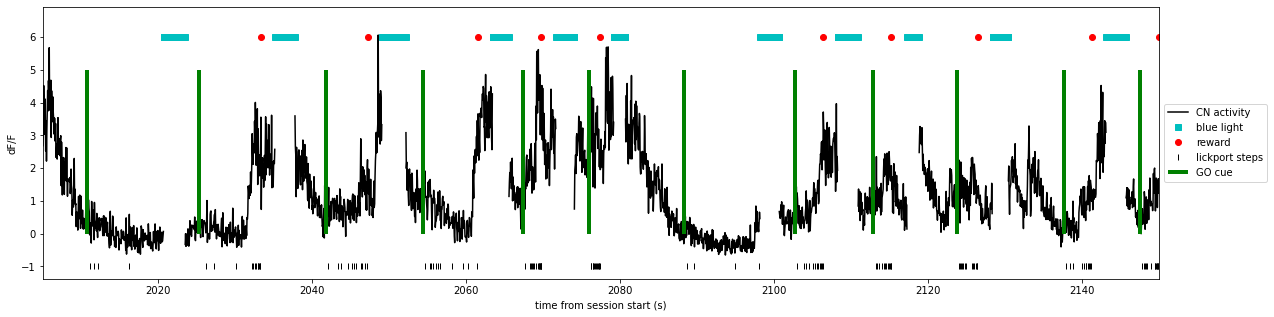

In [228]:
offset = -1
fig = plt.figure(figsize = [20,5])
ax1 = fig.add_subplot(111)
t = framenums/fs
photostim_indices = np.isnan(np.nanmean(data_dict[session]['F_sessionwise'],0))[framenums]
ax1.plot(t,data_dict[session]['dff_sessionwise'][data_dict[session]['cn'][15],framenums],'k-',label = 'CN activity')

ax1.plot(t[photostim_indices],np.ones(sum(photostim_indices))*6,'cs',label = 'blue light')
ax1.plot(t[np.where(reward_trace)[0]],np.ones(sum(reward_trace))*6,'ro',label = 'reward')
ax1.plot(t[np.where(lickport_step_trace)[0]],np.ones(sum(lickport_step_trace))*offset,'k|',label = 'lickport steps')

#ax1.plot(t[np.where(trial_start_trace)[0]],np.ones(sum(trial_start_trace))*offset,'go')
ax1.vlines(t[np.where(trial_start_trace)[0]],0,5,'green',linewidth = 4,label = 'GO cue')

ax1.set_xlim([2780,2850])
ax1.set_xlim([2005,2150])
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xlabel('time from session start (s)')
ax1.set_ylabel('dF/F')

/tmp/ipykernel_23905/2681147989.py:7: RuntimeWarning: Mean of empty slice
  photostim_indices = np.isnan(np.nanmean(F,0))


(0.5, 1.2)

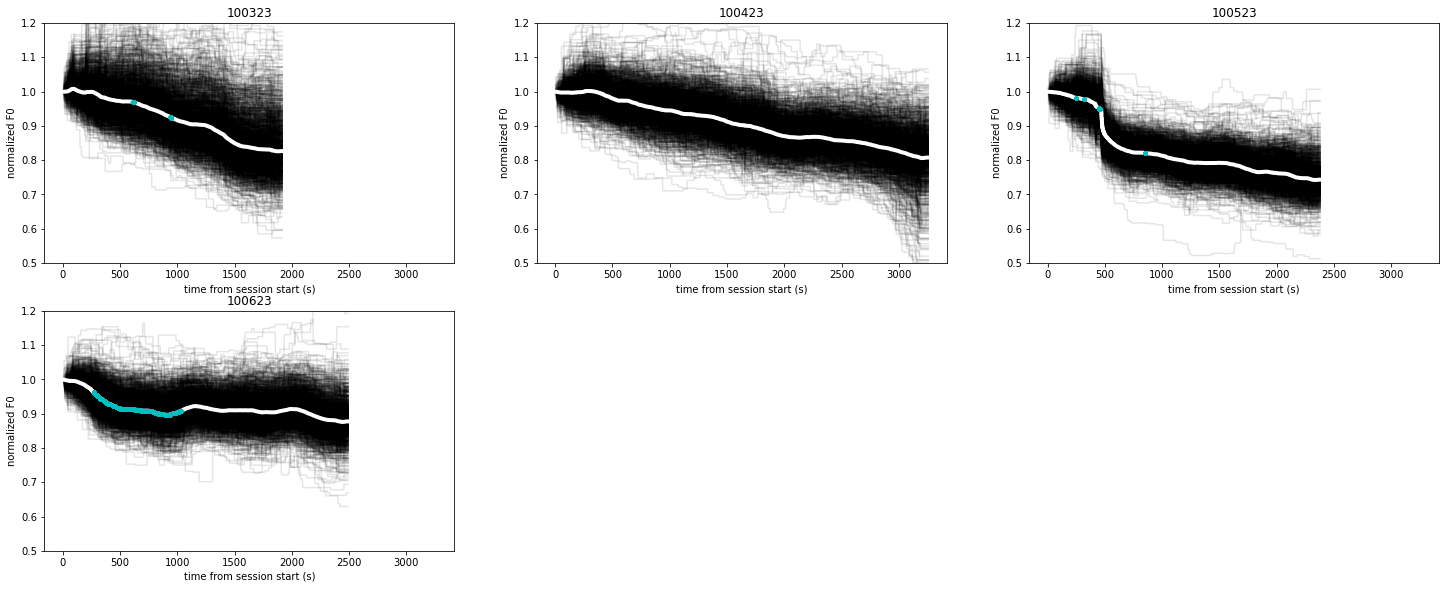

In [2]:
# bleaching
fig =plt.figure(figsize = [25,15])
for session_i,session in enumerate(sessions):
    F0 = data_dict[session]['F0_sessionwise'] #F0_sessionwise
    F0_norm = F0/np.nanmean(F0[:,:100],1)[:,np.newaxis]
    F = data_dict[session]['F_sessionwise']
    photostim_indices = np.isnan(np.nanmean(F,0))
    if session_i == 0:
        ax = fig.add_subplot(3,3,session_i+1)
        ax_orig = ax
    else:
        ax = fig.add_subplot(3,3,session_i+1,sharex = ax_orig,sharey = ax_orig)
    #plt.imshow(F0,aspect = 'auto',interpolation = 'none')
    mean_f0 = np.mean(F0,0)
    mean_f0 = mean_f0/np.nanmean(mean_f0[:100])
    
    
    t = np.arange(len(mean_f0))/data_dict[session]['sampling_rate']
    ax.plot(t,F0_norm.T,'k-',alpha = .1)
    ax.plot(t,mean_f0,'w-',linewidth = 4)
    ax.plot(t[np.where(photostim_indices)[0]],mean_f0[photostim_indices],'c.')
    ax.set_title(session)
    ax.set_xlabel('time from session start (s)')
    ax.set_ylabel('normalized F0')
ax.set_ylim([.5,1.2])
    #asd

In [4]:
if len(photostim_trials)<10:
    photostim_trials = np.asarray([])

NameError: name 'photostim_trials' is not defined

/tmp/ipykernel_23905/1695055935.py:36: RuntimeWarning: Mean of empty slice
  normalized_trial_locked_activity = trial_locked_activity-np.nanmean(trial_locked_activity[:,baseline_indices[0]:baseline_indices[1]],1)[:,np.newaxis]


IndexError: arrays used as indices must be of integer (or boolean) type

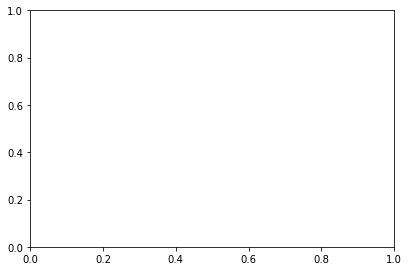

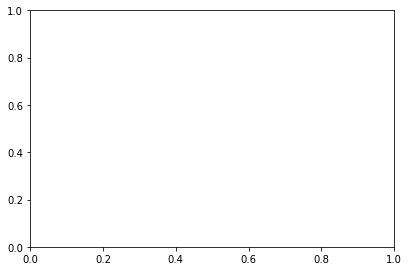

In [5]:
# Tuning changes of the CNs over multiple sessions

def plot_cn_photostim_sessions(trial_locked_matrix_name,
                               trial_locked_photostim_name,
                               cn_list,
                               sessions,
                               xlabel,
                               data_dict,
                               baseline_ends,
                               xlimits):
    fig = plt.figure(figsize = [30,20])
    ax_idx = 0
    fig_average = plt.figure(figsize = [30,20])
    average_ax_list = []
    session = sessions[0]
    previous_session_activity_list = []
    for cn_i,cn in enumerate(cn_list):
        previous_session_activity_list.append(np.zeros_like(data_dict[session]['time_since_trial_start'])*np.nan)
    for session_i,session in enumerate(sessions):
        
        for cn_i,cn in enumerate(cn_list):
            ax_idx+=1
            trial_locked_activity = data_dict[session][trial_locked_matrix_name][:,cn,:].squeeze().T
            photostim_trials = np.where(np.nanmax(data_dict[session][trial_locked_photostim_name].squeeze(),0)==1)[0]
            if len(photostim_trials)<10:# just PMT trips
                photostim_trials = np.asarray([],int)
            non_photostim_trials = np.where(np.nanmax(data_dict[session][trial_locked_photostim_name].squeeze(),0)==0)[0]
            ax_trial_locked_activity = fig.add_subplot(len(sessions),len(cn_list),ax_idx)
            if session_i ==0:
                ax_trial_locked_mean_activity = fig_average.add_subplot(len(sessions),len(cn_list),ax_idx)
                average_ax_list.append(ax_trial_locked_mean_activity)
            else:
                ax_trial_locked_mean_activity = fig_average.add_subplot(len(sessions),len(cn_list),ax_idx,sharey = average_ax_list[cn_i])
            
            baseline_indices = [np.argmax(data_dict[session]['time_since_trial_start']>baseline_ends[0]),np.argmax(data_dict[session]['time_since_trial_start']>baseline_ends[1])]
            normalized_trial_locked_activity = trial_locked_activity-np.nanmean(trial_locked_activity[:,baseline_indices[0]:baseline_indices[1]],1)[:,np.newaxis]
            mean_photostim_trace = np.nanmean(normalized_trial_locked_activity[photostim_trials,:],0)
            mean_non_photostim_trace = np.nanmean(normalized_trial_locked_activity[non_photostim_trials,:],0)
            needed_indices = (data_dict[session]['time_since_trial_start']>xlimits[0]) & (data_dict[session]['time_since_trial_start']<xlimits[1])
            
            ax_trial_locked_mean_activity.plot(data_dict[session]['time_since_trial_start'][needed_indices],previous_session_activity_list[cn_i][needed_indices],'k-')    
            previous_session_activity_list[cn_i] = np.nanmean(normalized_trial_locked_activity,0)
            ax_trial_locked_mean_activity.plot(data_dict[session]['time_since_trial_start'][needed_indices],mean_photostim_trace[needed_indices],'c-')    
            ax_trial_locked_mean_activity.plot(data_dict[session]['time_since_trial_start'][needed_indices],mean_non_photostim_trace[needed_indices],'m-')    
            
            ax_trial_locked_activity.imshow(trial_locked_activity,
                                            aspect = 'auto',
                                            extent = [data_dict[session]['time_since_trial_start'][0],data_dict[session]['time_since_trial_start'][-1],trial_locked_activity.shape[0],1],
                                            interpolation = 'none')
            ax_trial_locked_activity.plot(np.ones(len(photostim_trials))*xlimits[0]+.02*np.diff(xlimits)[0],photostim_trials,'cs')
            if cn_i == 0:
                ax_trial_locked_activity.set_ylabel('{}\ntrial#'.format(session))
                ax_trial_locked_mean_activity.set_ylabel('{}\ndF/F'.format(session))
            if session_i == 0:
                ax_trial_locked_activity.set_title('neuron {}'.format(cn))
                ax_trial_locked_mean_activity.set_title('neuron {}'.format(cn))
                
            if cn == data_dict[session]['cn'][10]:
                ax_trial_locked_activity.spines['bottom'].set_color('magenta')
                ax_trial_locked_activity.spines['top'].set_color('magenta') 
                ax_trial_locked_activity.spines['right'].set_color('magenta')
                ax_trial_locked_activity.spines['left'].set_color('magenta')
                ax_trial_locked_activity.spines['bottom'].set_linewidth(5)
                ax_trial_locked_activity.spines['top'].set_linewidth(5)
                ax_trial_locked_activity.spines['right'].set_linewidth(5)
                ax_trial_locked_activity.spines['left'].set_linewidth(5)
                ax_trial_locked_mean_activity.spines['bottom'].set_color('magenta')
                ax_trial_locked_mean_activity.spines['top'].set_color('magenta') 
                ax_trial_locked_mean_activity.spines['right'].set_color('magenta')
                ax_trial_locked_mean_activity.spines['left'].set_color('magenta')
                ax_trial_locked_mean_activity.spines['bottom'].set_linewidth(5)
                ax_trial_locked_mean_activity.spines['top'].set_linewidth(5)
                ax_trial_locked_mean_activity.spines['right'].set_linewidth(5)
                ax_trial_locked_mean_activity.spines['left'].set_linewidth(5)
                
                
            if session_i == len(sessions)-1:
                ax_trial_locked_activity.set_xlabel(xlabel)
                ax_trial_locked_mean_activity.set_xlabel(xlabel)
            ax_trial_locked_activity.set_xlim(xlimits)
            ax_trial_locked_mean_activity.set_xlim(xlimits)
trial_locked_matrix_name = 'dff_trialwise_closed_loop'
trial_locked_photostim_name = 'PMT_off_trialwise_closed_loop'
plot_cn_photostim_sessions(trial_locked_matrix_name,
                           trial_locked_photostim_name,
                           cn_list,
                           sessions,
                          'time from trial start (s)',
                          data_dict,
                          [-2,0],
                          [-2.5,8])
trial_locked_matrix_name = 'dff_trialwise_reward_closed_loop'
trial_locked_photostim_name = 'PMT_off_reward_closed_loop'
plot_cn_photostim_sessions(trial_locked_matrix_name,
                           trial_locked_photostim_name,
                           cn_list,
                           sessions,
                           'time from reward (s)',
                          data_dict,
                           [-2,0],
                           [-2.5,1.8])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [2]:
from rastermap import Rastermap
import scipy
model = Rastermap(n_components=2, n_X=50, nPC=100, init='pca')
a = scipy.stats.zscore(data_dict[session]['dff_sessionwise'],1)
model.fit(a)


#im_events = ax.imshow(events_zscore[model.isort,:],aspect = 'auto', interpolation = 'none')  

nmin 100
0.29870009422302246
7.314893960952759
7.504754304885864
7.510336875915527
(2400, 2500)
(80,)
1.0
time; iteration;  explained PC variance
0.93s     0        0.2002      8
2.77s    10        0.4257      24
4.62s    20        0.5173      80
6.49s    30        0.6534      360
8.74s    40        0.7443      840
10.71s    50        0.8135      1520
12.81s    60        0.8859      2400
14.94s    70        0.8865      2400
16.86s   final      0.8865
25.68s upsampled    0.8865


In [2]:
#%% calculate event rate and stuff like that

# TODO amplitude should be calculated for each transient separately, then averaged over transients
# this way the long tails of long trials won't interfere
from pathlib import Path


cut_reward_activity = False
ignore_synchronous_events = True
#% calculate event rate
min_event_step = 5 # @20Hz - length of event # 10 for 6s, 5 for 8s
minimum_d_prime = 3# 5 for 6s
time_to_average_after_trial_start = 8 #seconds
baseline_end_t = -.5 # seconds before GO cue
baseline_start_t = -1.5 # seconds before GO cue

file_list_to_copy_over = ['Z-positions.pdf',
                          'session_meanimages.tiff',
                          'ROI_sizes.pdf',
                          'ROIs.pdf',
                          'stat.mat',
                          'XYZ_motion.pdf',
                          'session_refImages.tiff',
                          'ops.mat']
#%

pixel_num_list = []
for s in stat:
    pixel_num_list.append(np.sum(s['soma_crop']))# &(s['overlap']==False)))
    #break
pixel_num_list=np.asarray(pixel_num_list)
    #%
for last_session in sessions: 
    
    mean_activity_matrix_normalized_previous_CN = None
    if 'dff_trialwise_closed_loop_previous_CN' in data_dict[last_session].keys():
        trialwise_matrix_name = 'dff_trialwise_closed_loop_previous_CN'#'dff_trialwise_all'
        trialwise_reward_matrix_name = 'dff_trialwise_reward_closed_loop_previous_CN'#'dff_trialwise_all'
        trialwise_dff_until_reward = data_dict[last_session][trialwise_matrix_name].copy()
        if trialwise_dff_until_reward.shape[2]==0:
            trialwise_matrix_name = 'dff_trialwise_all'
            trialwise_dff_until_reward = data_dict[last_session][trialwise_matrix_name].copy()
        #trialwise_reward_matrix = np.nan*trialwise_dff_until_reward
        trialwise_reward_matrix = data_dict[last_session][trialwise_reward_matrix_name].copy()
        step_back =np.argmax(data_dict[last_session]['time_since_trial_start']>0) -1
        trial_len = len(data_dict[last_session]['time_since_trial_start'])
        for trial_i, reward_time in enumerate(data_dict[last_session]['reward_times_previous_CN']):
            if len(reward_time)>0:

                reward_idx = np.argmax(data_dict[last_session]['time_since_trial_start']>reward_time[0])
                if reward_idx == 0:
                    reward_idx = len(data_dict[last_session]['time_since_trial_start'])
                #print(['rewarded',reward_idx])
                if cut_reward_activity:
                    trialwise_dff_until_reward[reward_idx:,:,trial_i] = np.nan
                
                #trialwise_reward_matrix[:step_back+trial_len-reward_idx,:,trial_i] = data_dict[last_session][trialwise_matrix_name][reward_idx-step_back:,:,trial_i]
        mean_reward_matrix = np.nanmean(trialwise_reward_matrix,2).T
        std_reward_matrix = np.nanstd(trialwise_reward_matrix,2).T
        mean_activity_matrix = np.nanmean(trialwise_dff_until_reward,2).T
        baseline_length = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times_previous_CN'][0][0])#
        baseline_end = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times_previous_CN'][0][0]+baseline_end_t)#
        baseline_start = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times_previous_CN'][0][0]+baseline_start_t)#
        amplitude_length = np.argmax(data_dict[last_session]['time_since_trial_start']>time_to_average_after_trial_start)
        mean_activity_matrix_normalized_previous_CN = mean_activity_matrix-np.nanmean(mean_activity_matrix[:,baseline_start:baseline_end],1)[:,np.newaxis]#/np.nanmean(mean_activity_matrix[:,:baseline_length],1)[:,np.newaxis] # TODO division is not needed here once real df/f is exported..
        mean_activity_matrix_normalized_previous_CN[np.isnan(mean_activity_matrix_normalized_previous_CN)] = 0
        mean_activity_matrix_normalized_previous_CN[np.isinf(mean_activity_matrix_normalized_previous_CN)] = 0

        data_dict[last_session]['mean_activity_matrix_previous_cn'] = mean_activity_matrix
        data_dict[last_session]['mean_reward_matrix_previous_cn'] = mean_reward_matrix
    
    trialwise_matrix_name = 'dff_trialwise_closed_loop'#'dff_trialwise_all'
    trialwise_reward_matrix_name = 'dff_trialwise_reward_closed_loop'#'dff_trialwise_all'

    trialwise_dff_until_reward = data_dict[last_session][trialwise_matrix_name].copy()
    if trialwise_dff_until_reward.shape[2]==0:
        trialwise_matrix_name = 'dff_trialwise_all'
        trialwise_dff_until_reward = data_dict[last_session][trialwise_matrix_name].copy()
    #trialwise_reward_matrix = np.nan*trialwise_dff_until_reward
    trialwise_reward_matrix = data_dict[last_session][trialwise_reward_matrix_name].copy()
    step_back =np.argmax(data_dict[last_session]['time_since_trial_start']>0) -1
    trial_len = len(data_dict[last_session]['time_since_trial_start'])
    for trial_i, reward_time in enumerate(data_dict[last_session]['reward_times']):
        if len(reward_time)>0:
            
            reward_idx = np.argmax(data_dict[last_session]['time_since_trial_start']>reward_time[0])
            if reward_idx == 0:
                reward_idx = len(data_dict[last_session]['time_since_trial_start'])
            #print(['rewarded',reward_idx])
            if cut_reward_activity:
                trialwise_dff_until_reward[reward_idx:,:,trial_i] = np.nan
           # trialwise_reward_matrix[:step_back+trial_len-reward_idx,:,trial_i] = data_dict[last_session][trialwise_matrix_name][reward_idx-step_back:,:,trial_i]
    mean_reward_matrix = np.nanmean(trialwise_reward_matrix,2).T
    std_reward_matrix = np.nanstd(trialwise_reward_matrix,2).T
    mean_activity_matrix = np.nanmean(trialwise_dff_until_reward,2).T
    baseline_length = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times'][0][0])#
    baseline_end = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times'][0][0]+baseline_end_t)#
    baseline_start = np.argmax(data_dict[last_session]['time_since_trial_start']>data_dict[last_session]['go_cue_times'][0][0]+baseline_start_t)#
    amplitude_length = np.argmax(data_dict[last_session]['time_since_trial_start']>time_to_average_after_trial_start)
    mean_activity_matrix_normalized = mean_activity_matrix-np.nanmean(mean_activity_matrix[:,baseline_start:baseline_end],1)[:,np.newaxis]#/np.nanmean(mean_activity_matrix[:,:baseline_length],1)[:,np.newaxis] # TODO division is not needed here once real df/f is exported..
    mean_activity_matrix_normalized[np.isnan(mean_activity_matrix_normalized)] = 0
    mean_activity_matrix_normalized[np.isinf(mean_activity_matrix_normalized)] = 0
    
    data_dict[last_session]['mean_activity_matrix'] = mean_activity_matrix
    data_dict[last_session]['mean_reward_matrix'] = mean_reward_matrix
    

    amplitude = np.nanmean(mean_activity_matrix_normalized[:,baseline_length:amplitude_length],1)
    # amplitude[amplitude>1] = 1
    # amplitude[amplitude<-1] = -1
    stdev = np.nanstd(mean_activity_matrix_normalized[:,baseline_length:amplitude_length],1)
    #%
    events = data_dict[last_session]['signal_to_noise_trace']>minimum_d_prime
    if ignore_synchronous_events:
        events = events & (np.nanmean(data_dict[last_session]['signal_to_noise_trace'],0)<minimum_d_prime)[np.newaxis,:]
    event_edges = np.diff(np.concatenate([np.zeros([events.shape[0],1]),events,np.zeros([events.shape[0],1])],1))
    events_clean = np.zeros(events.shape)
    event_num = []
    event_amplitude = []
    
    
        
    for i,line in enumerate(event_edges):
        starts = np.where(line==1)[0]
        ends = np.where(line==-1)[0]
        lengths = ends-starts
        amplitudes = []
        for idx in np.where(lengths>=min_event_step)[0]:
            events_clean[i,starts[idx]:ends[idx]]=np.ones(lengths[idx])*np.nanmean(data_dict[last_session]['dff_sessionwise'][i,starts[idx]:ends[idx]])#*data_dict[last_session]['photon_counts']['dprime_1dFF'][i]
            #events_clean[i,starts[idx]:ends[idx]]=data_dict[last_session]['dff_sessionwise'][i,starts[idx]:ends[idx]]
            amplitudes.append(np.max(data_dict[last_session]['dff_sessionwise'][i,starts[idx]:ends[idx]]))
        event_amplitude.append(np.mean(amplitudes))
        event_num.append(len(np.where(lengths>=min_event_step)[0]))
    events_clean[np.isnan(events_clean)] = 0
    events_clean[np.isinf(events_clean)] = 0
    event_rate = np.asarray(event_num)/(events.shape[1]/20/60)
    amplitude_rate = np.sum(events_clean,1)/(events.shape[1]/20)
    amplitude_rate[amplitude_rate<.001] = .001 #avoid zeros
    event_rate[event_rate<.001] = .001 #avoid zeros
    data_dict[last_session]['event_rate'] = event_rate
    data_dict[last_session]['amplitude_rate'] = amplitude_rate
    data_dict[last_session]['events_clean'] = events_clean
    data_dict[last_session]['trial_averaged_amplitude'] = amplitude
    
    go_cue_times = data_dict[last_session]['go_cue_times']
    reward_times = data_dict[last_session]['reward_times']
    threshold_crossing_times = data_dict[last_session]['threshold_crossing_times']
    reward_list = []
    threshold_crossing_list = []
    for g,r,t in zip(go_cue_times,reward_times,threshold_crossing_times):
        if len(r)>0:
            reward_list.append(True)
            threshold_crossing_list.append(t[0])
        else:
            reward_list.append(False)
            threshold_crossing_list.append(np.nan)
    data_dict[last_session]['rewarded_trials'] = np.asarray(reward_list)
    data_dict[last_session]['time_to_reward'] = np.asarray(threshold_crossing_list)
    
    
    try:
        go_cue_times = data_dict[last_session]['go_cue_times_previous_CN']
        reward_times = data_dict[last_session]['reward_times_previous_CN']
        threshold_crossing_times = data_dict[last_session]['threshold_crossing_times_previous_CN']
        reward_list = []
        threshold_crossing_list = []
        for g,r,t in zip(go_cue_times,reward_times,threshold_crossing_times):
            if len(r)>0:
                reward_list.append(True)
                threshold_crossing_list.append(t[0])
            else:
                reward_list.append(False)
                threshold_crossing_list.append(np.nan)
        data_dict[last_session]['rewarded_trials_previous_CN'] = np.asarray(reward_list)
        data_dict[last_session]['time_to_reward_previous_CN'] = np.asarray(threshold_crossing_list)
    except:
        print('no previous_cn')
    

/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


no previous_cn


/tmp/ipykernel_3119/2233604163.py:93: RuntimeWarning: Mean of empty slice
  mean_reward_matrix = np.nanmean(trialwise_reward_matrix,2).T
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3119/2233604163.py:115: RuntimeWarning: Mean of empty slice
  events = events & (np.nanmean(data_dict[last_session]['signal_to_noise_trace'],0)<minimum_d_prime)[np.newaxis,:]


no previous_cn
no previous_cn
no previous_cn
no previous_cn
no previous_cn
no previous_cn


In [45]:
data_dict_big.keys()

dict_keys(['BCI_59', 'BCI_60'])

In [70]:
#Add to master dict 
#data_dict_big = {}
data_dict_big[subject] = data_dict.copy()
data_dict_big[subject].keys()

dict_keys(['092523', '092623', '092723', '092823', '092923'])

In [49]:
# add session comment

metadata_dir = '/home/jupyter/bucket/Metadata'
import datetime
import pandas as pd
for subject in data_dict_big.keys():
    try:
        subject_metadata = pd.read_csv(os.path.join(metadata_dir,subject.replace('_','')+'.csv'))
    except:
        try:
            subject_metadata = pd.read_csv(os.path.join(metadata_dir,subject+'.csv'))
        except:
            print('no metadata found')
            continue
    print(subject)


    sessions = list(data_dict_big[subject].keys())
    session_date_dict = {}
    for session in sessions:
        try:
            session_date = datetime.datetime.strptime(session,'%m%d%y')
        except:
            try:
                session_date = datetime.datetime.strptime(session,'%Y-%m-%d')
            except:
                try:
                    session_date = datetime.datetime.strptime(session[:6],'%m%d%y')
                except:
                    print('cannot understand date for session dir: {}'.format(session))
                    continue
        if session_date.date() in session_date_dict.keys():
            print('there were multiple sessions on {}'.format(session_date.date()))
            session_date_dict[session_date.date()] = [session_date_dict[session_date.date()],session]
        else:
            session_date_dict[session_date.date()] = session
        data_dict_big[subject][session]['session_comment'] = subject_metadata.loc[subject_metadata['Date']==str(session_date.date()).replace('-','/')]['Comment'].values[0]

BCI_59
BCI_60
BCI_58


In [208]:
data_dict_big[subject][session]['session_comment']

'original task - return to previous CN in the beginning'

In [70]:
#### calculate behavioral stuff.

is_it_previous_cn = False
if is_it_previous_cn:
    extra_txt = '_previous_CN'
else:
    extra_txt = ''
def movingaverage(DFF,win,function = 'mean'):
    taper = np.ones(win)*np.nan
    DFF = np.concatenate([DFF,taper])
    dff_list = []
    for i in range(win):
        dff_list.append(np.roll(DFF,i*-1,axis = 0))
    if function == 'mean':
        DFF_averaged = np.nanmean(np.asarray(dff_list),0).squeeze()
    elif function == 'median':
        DFF_averaged = np.nanmedian(np.asarray(dff_list),0).squeeze()
    DFF_averaged = DFF_averaged[:-win]
    return DFF_averaged


needed_comments = ['original']#['anti','pair']#['pair']
excluded_comments = []#['anti']

trials_needed = 100
averaging_window = 10
rewarded_trials_list = []
time_to_reward_list = []
for subject in data_dict_big.keys():
    print(subject)
    sessions = data_dict_big[subject].keys()
    for session in sessions:
        #print(data_dict_big[subject][session]['session_comment'])
        session_is_needed =True
        for c in needed_comments:
            session_is_needed = session_is_needed and c in data_dict_big[subject][session]['session_comment']
        for c in excluded_comments:
            session_is_needed = session_is_needed and c not in data_dict_big[subject][session]['session_comment']
        #print([data_dict_big[subject][session]['session_comment'],session_is_needed])
        if not session_is_needed:
            continue
        print(session)
        try:
            rewarded_trials_now = data_dict_big[subject][session]['rewarded_trials'+extra_txt]
            if averaging_window>1:
                rewarded_trials_now = movingaverage(rewarded_trials_now,averaging_window)
            rewarded_trials_now_ = np.ones(trials_needed)*np.nan
            rewarded_trials_now_[:min([len(rewarded_trials_now),len(rewarded_trials_now_)])] = rewarded_trials_now[:min([len(rewarded_trials_now),len(rewarded_trials_now_)])]
            rewarded_trials_list.append(rewarded_trials_now_)

            time_to_reward_now = data_dict_big[subject][session]['time_to_reward'+extra_txt]
            if averaging_window>1:
                time_to_reward_now = movingaverage(time_to_reward_now,averaging_window,function = 'mean')
            time_to_reward_now_ = np.ones(trials_needed)*np.nan
            time_to_reward_now_[:min([len(time_to_reward_now),len(time_to_reward_now_)])] = time_to_reward_now[:min([len(time_to_reward_now),len(time_to_reward_now_)])]
            time_to_reward_list.append(time_to_reward_now_)
        except:
            pass
        #asda
        
        
rewarded_trials_list = np.asarray(rewarded_trials_list)
time_to_reward_list = np.asarray(time_to_reward_list)

order = np.argsort(np.nanmean(rewarded_trials_list[:,:5],1)) #np.nanmean(rewarded_trials_list[:,30:60],1)-
rewarded_trials_list = rewarded_trials_list[order,:]
time_to_reward_list = time_to_reward_list[order,:]

    
    #plt.plot(movingaverage(data_dict[session]['rewarded_trials'],5))
    

BCI_59
070323
070523
070623
070723
BCI_60
070323
070523
070623
070723
071023
071123
071223
071323
BCI_58
070323
070523
070623
070723
071023
071123
071223
071323


/tmp/ipykernel_32069/435318682.py:15: RuntimeWarning: Mean of empty slice
  DFF_averaged = np.nanmean(np.asarray(dff_list),0).squeeze()


In [197]:
rewarded_trials_list

array([], dtype=float64)

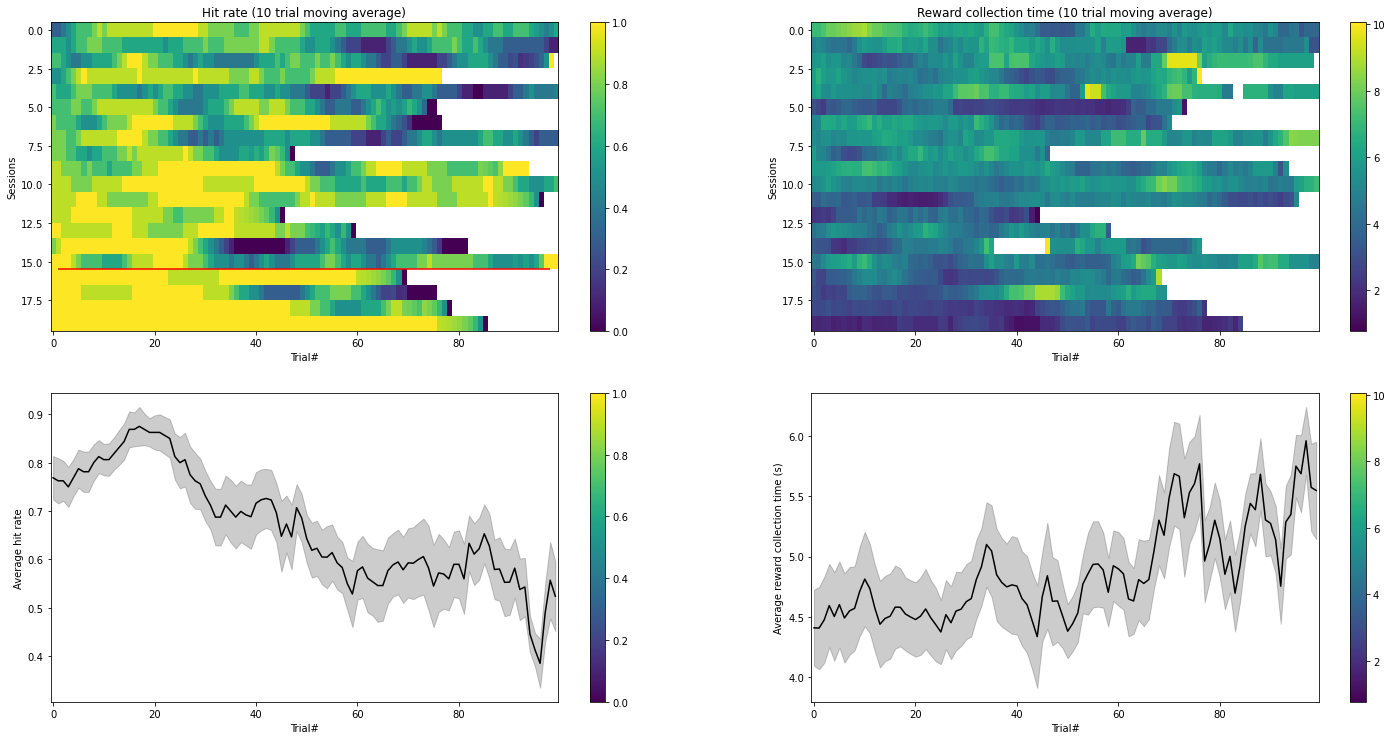

In [71]:
# behavior plot

fig  = plt.figure(figsize = [25,12.5])
baseline_trial_num = 0 # subtract the average of this many trial
max_reward_rate_start  = .99 # if reward rate is higher than this, skip session from plot


ax_im_rewrate  = fig.add_subplot(2,2,1)
needed = np.nanmean(rewarded_trials_list[:,:5],1)<=max_reward_rate_start
if baseline_trial_num==0:
    im = ax_im_rewrate.imshow(rewarded_trials_list[:,:],aspect = 'auto', interpolation = 'none') #-np.nanmean(rewarded_trials_list[:,:5],1)[:,np.newaxis]
else:
    im = ax_im_rewrate.imshow(rewarded_trials_list[:,:]-np.nanmean(rewarded_trials_list[:,:baseline_trial_num],1)[:,np.newaxis],aspect = 'auto', interpolation = 'none') #
ax_im_rewrate.hlines(np.argmin(needed)-.5,1,rewarded_trials_list.shape[1]-2,color = 'red')
ax_im_rewrate.set_ylabel('Sessions')
ax_im_rewrate.set_xlabel('Trial#')
ax_im_rewrate.set_title('Hit rate ({} trial moving average)'.format(averaging_window))
fig.colorbar(im, ax=ax_im_rewrate,location = 'right')


ax_plt_rewrate = fig.add_subplot(2,2,3,sharex = ax_im_rewrate)
x = np.arange(rewarded_trials_list.shape[1])
y = np.nanmean(rewarded_trials_list[needed,:],0)
yerr = np.nanstd(rewarded_trials_list[needed,:],0)/np.sqrt(sum(needed))
ax_plt_rewrate.plot(x,y,'k-')

ax_plt_rewrate.fill_between(x, y-yerr, y+yerr,color = 'black',alpha = .2)
fig.colorbar(im, ax=ax_plt_rewrate,location = 'right')

ax_plt_rewrate.set_ylabel('Average hit rate')
ax_plt_rewrate.set_xlabel('Trial#')


needed = rewarded_trials_list[:,0]<=max_reward_rate_start+100
ax_im_rewrtime  = fig.add_subplot(2,2,2)
if baseline_trial_num==0:
    im = ax_im_rewrtime.imshow(time_to_reward_list[needed,:],aspect = 'auto', interpolation = 'none') #-np.nanmean(time_to_reward_list[:,:20],1)[:,np.newaxis]
else:
    im = ax_im_rewrtime.imshow(time_to_reward_list[needed,:]-np.nanmean(time_to_reward_list[needed,:baseline_trial_num],1)[:,np.newaxis],aspect = 'auto', interpolation = 'none') #

ax_im_rewrtime.set_ylabel('Sessions')
ax_im_rewrtime.set_xlabel('Trial#')
ax_im_rewrtime.set_title('Reward collection time ({} trial moving average)'.format(averaging_window))
fig.colorbar(im, ax=ax_im_rewrtime,location = 'right')
    
    
ax_plt_rewtime = fig.add_subplot(2,2,4,sharex = ax_im_rewrtime)


x = np.arange(time_to_reward_list.shape[1])
y = np.nanmean(time_to_reward_list[:,:],0)
yerr = np.nanstd(time_to_reward_list[:,:],0)/np.sqrt(len(needed))
ax_plt_rewtime.plot(x,y,'k-')
ax_plt_rewtime.fill_between(x, y-yerr, y+yerr,color = 'black',alpha = .2)


ax_plt_rewtime.set_ylabel('Average reward collection time (s)')
ax_plt_rewtime.set_xlabel('Trial#')
fig.colorbar(im, ax=ax_plt_rewtime,location = 'right')

In [9]:
data_dict.keys()

dict_keys(['032023', '032123', '032223', '032423', '032723', '032823', '032923', '033123', '040323', '040423'])

In [148]:
data_dict[last_session].keys()

dict_keys(['file_path', 'file_name', 'subject', 'F_sessionwise', 'F_trialwise_all', 'F_trialwise_closed_loop', 'dff_sessionwise', 'dff_trialwise_all', 'dff_trialwise_closed_loop', 'cn', 'roiX', 'roiY', 'dist', 'FOV', 'session_date', 'session_path', 'mouse', 'mean_image', 'max_image', 'time_since_trial_start', 'go_cue_times', 'lick_times', 'reward_times', 'trial_times', 'hit', 'threshold_crossing_times', 'zaber_move_forward', 'sampling_rate', 'all_si_filenames', 'closed_loop_filenames', 'all_si_frame_nums', 'scanimage_filenames', 'photon_counts', 'f0_scalar', 'signal_to_noise_trace', 'F_trialwise_closed_loop_previous_CN', 'dff_trialwise_closed_loop_previous_CN', 'go_cue_times_previous_CN', 'reward_times_previous_CN', 'scanimage_filenames_previous_CN', 'lick_times_previous_CN', 'hit_previous_CN', 'threshold_crossing_times_previous_CN', 'zaber_move_forward_previous_CN', 'mean_activity_matrix_previous_cn', 'mean_reward_matrix_previous_cn', 'mean_activity_matrix', 'mean_reward_matrix', 'eve

In [68]:
pdf_obj.close()

nmin 50
0.026047945022583008
1.6180322170257568
1.6705529689788818
1.6718437671661377
(80, 100)
(32,)
1.0
time; iteration;  explained PC variance
0.01s     0        0.2275      8
0.08s    10        0.5995      48
0.15s    20        0.7226      80
0.21s    30        0.7225      80
0.22s   final      0.7225
1.69s upsampled    0.7225


/tmp/ipykernel_1352/2215930234.py:161: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = [16,8])


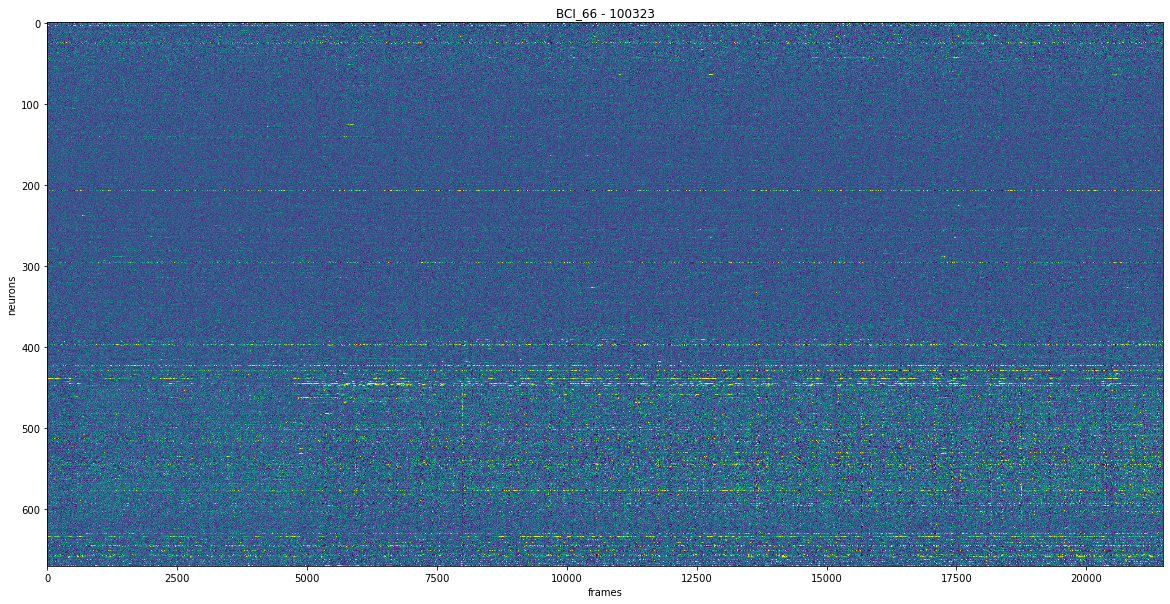

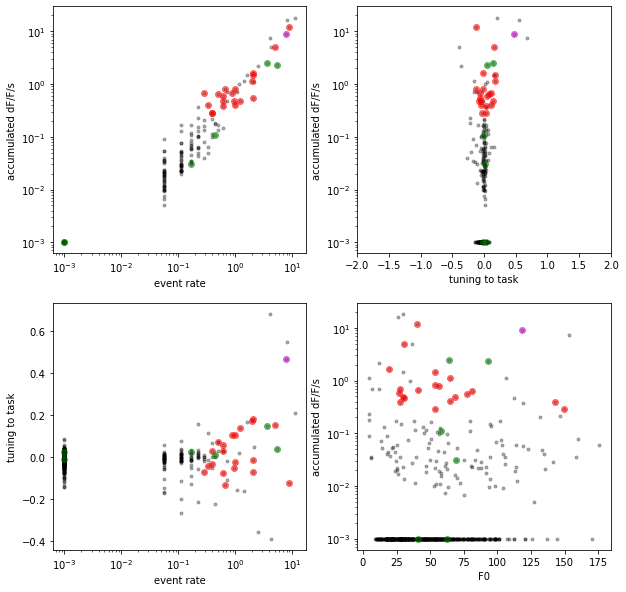

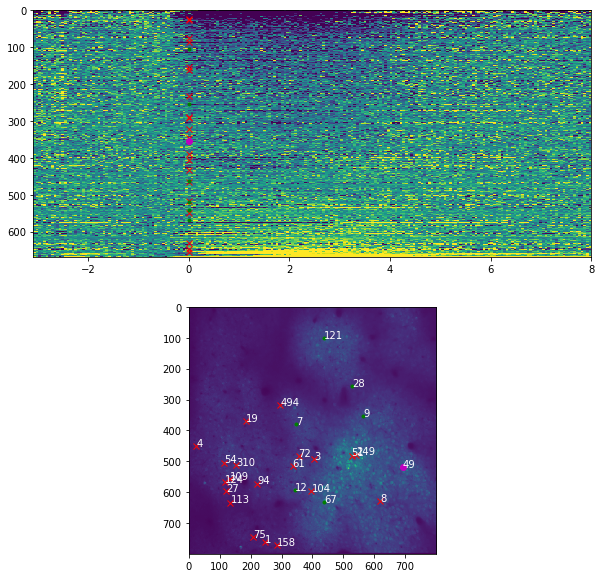

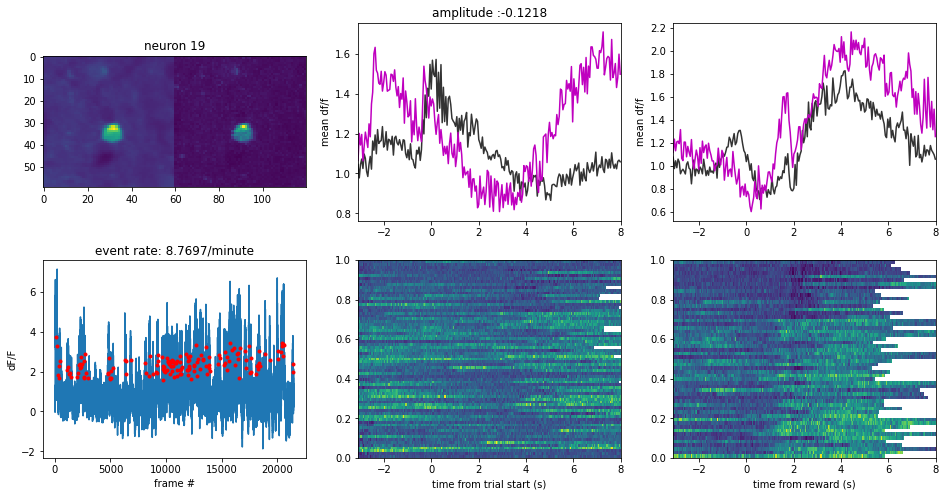

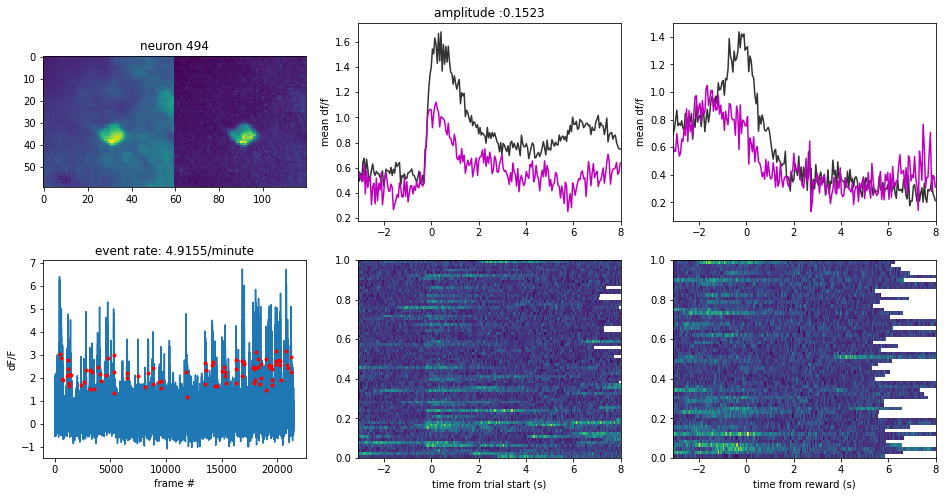

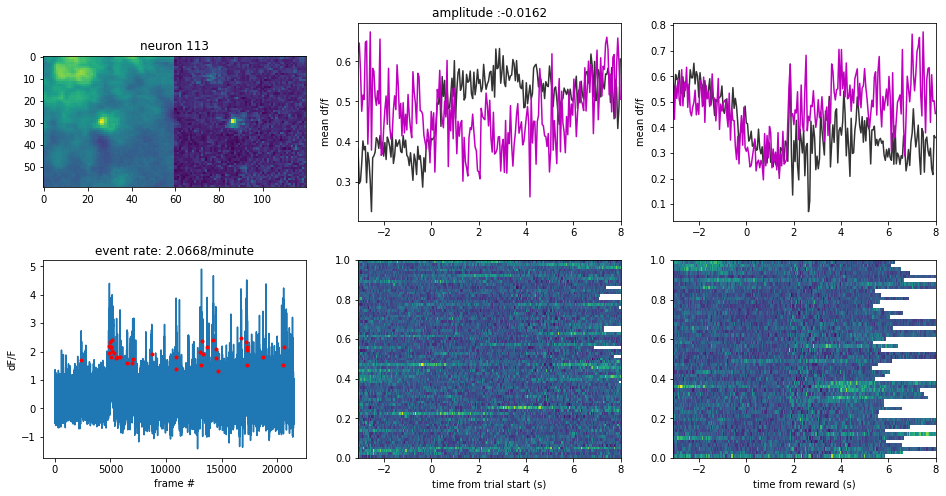

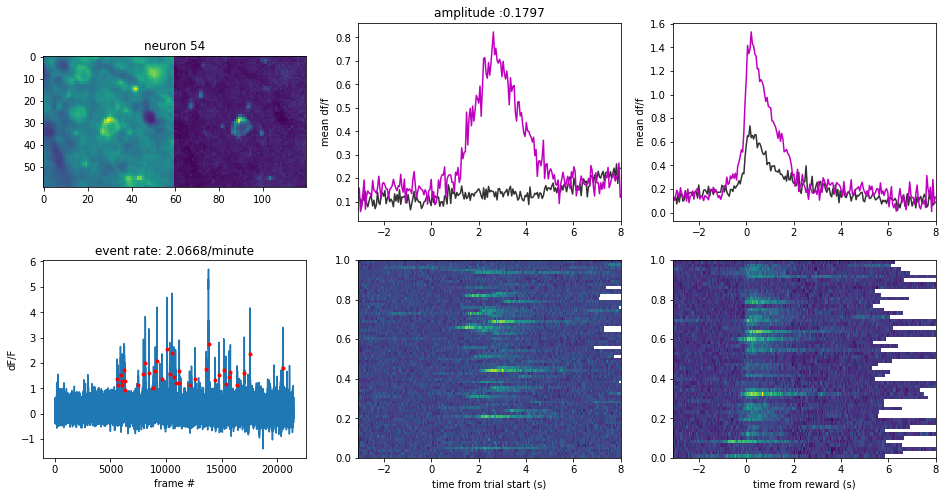

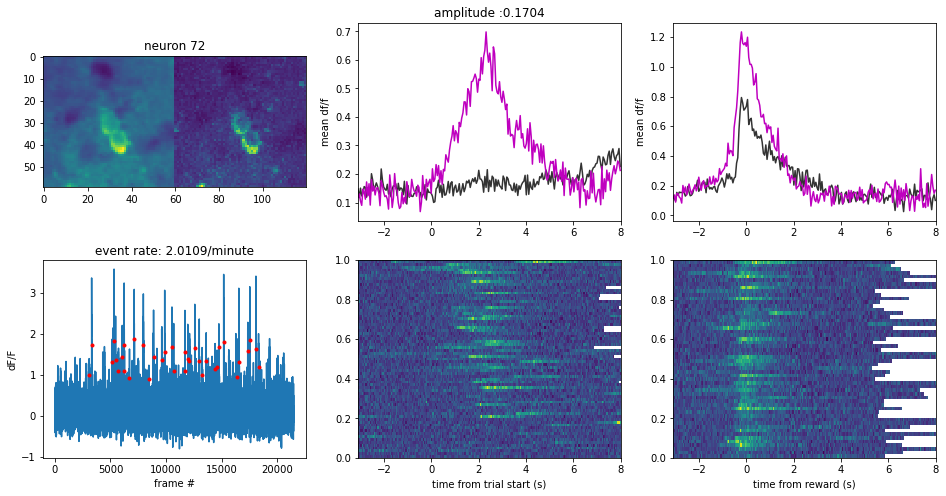

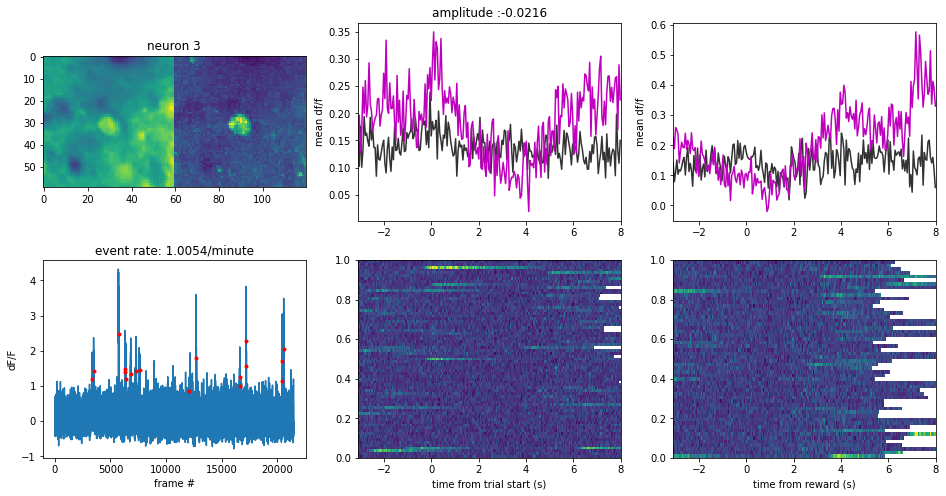

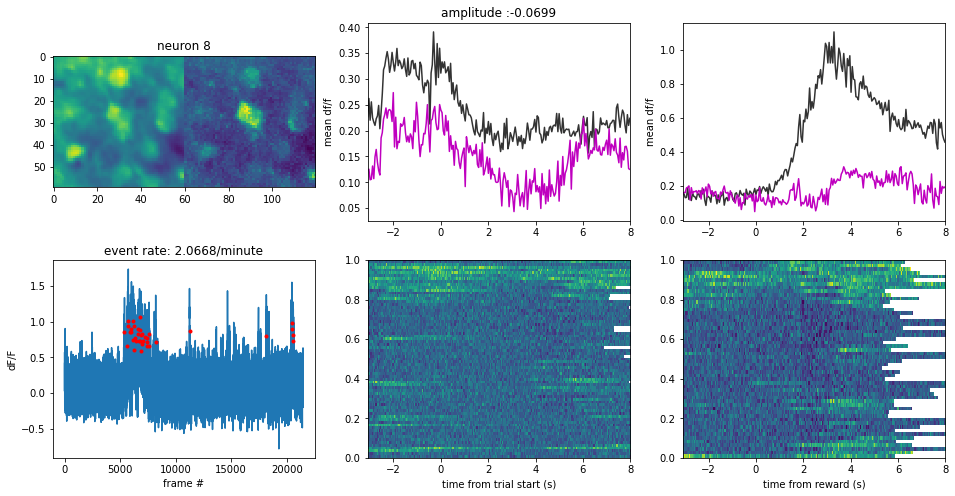

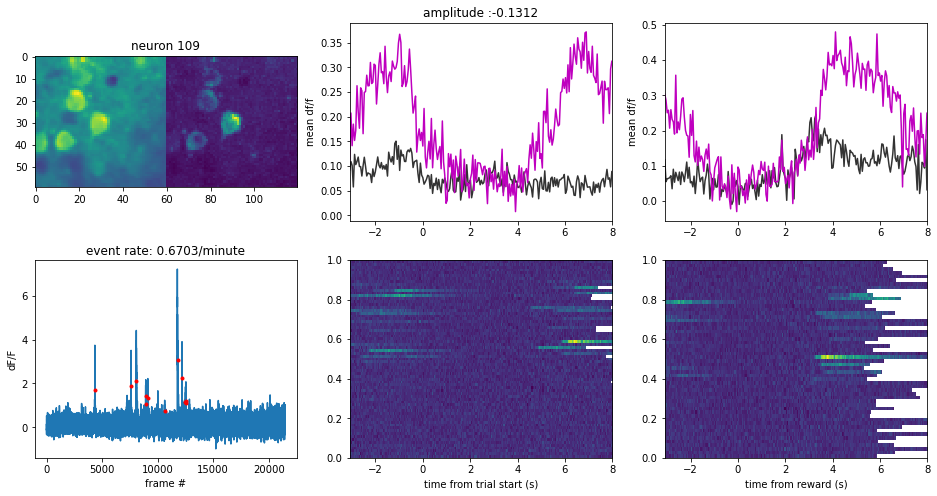

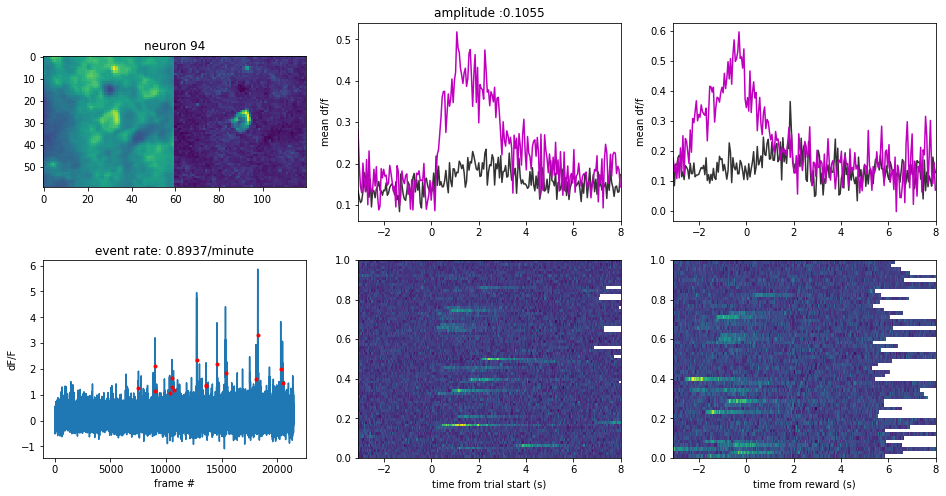

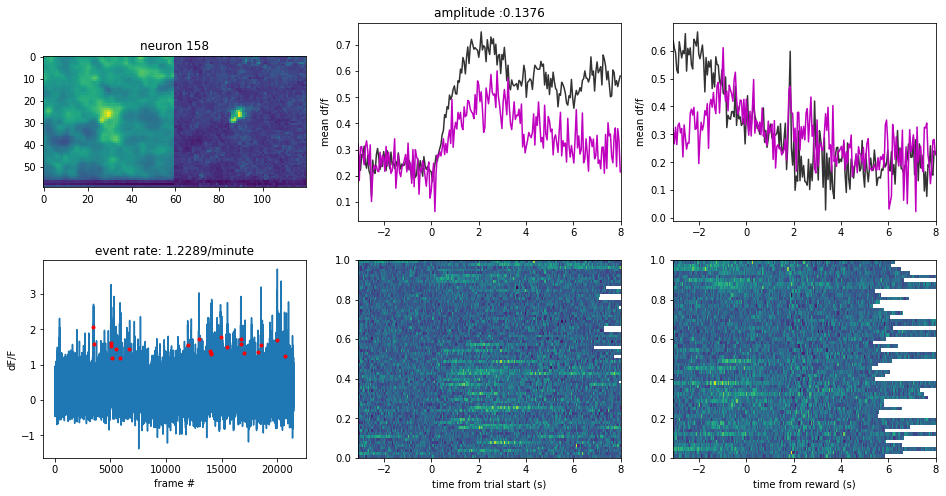

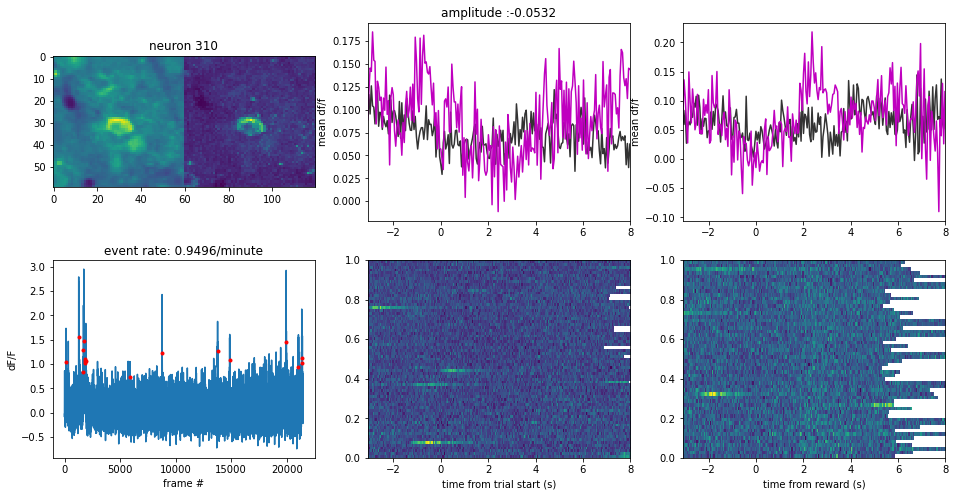

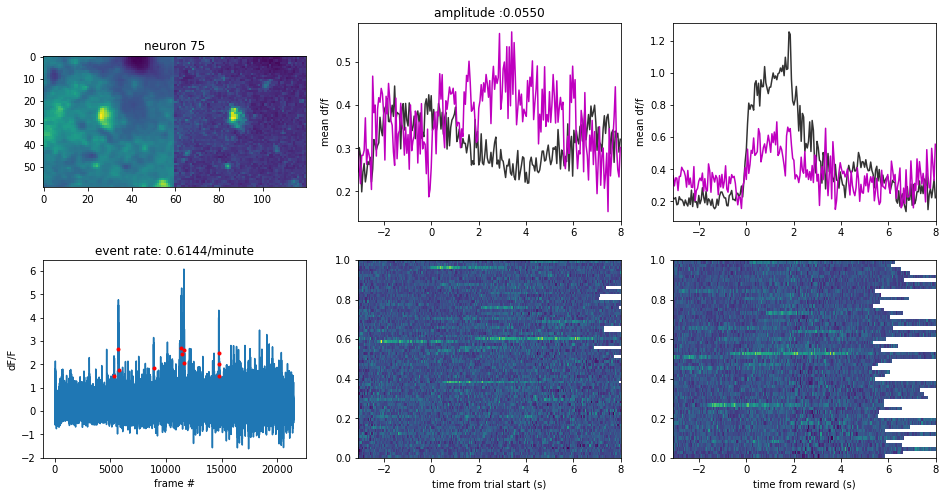

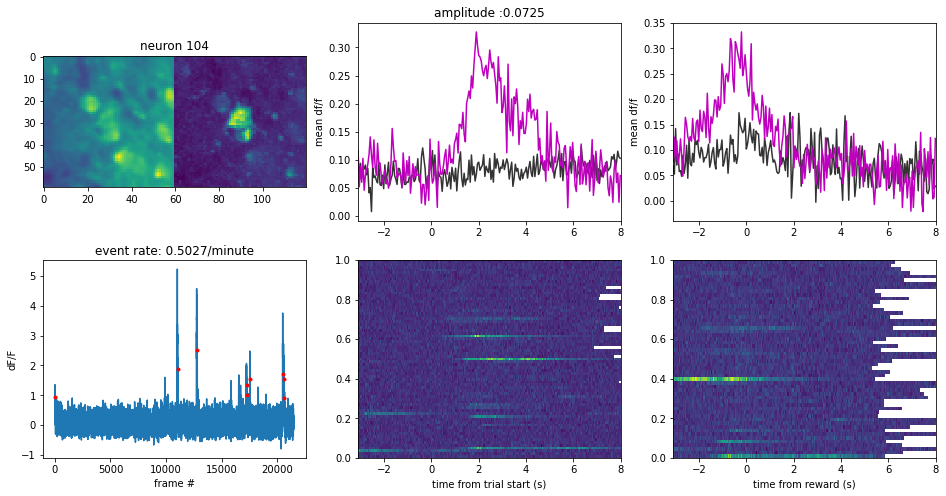

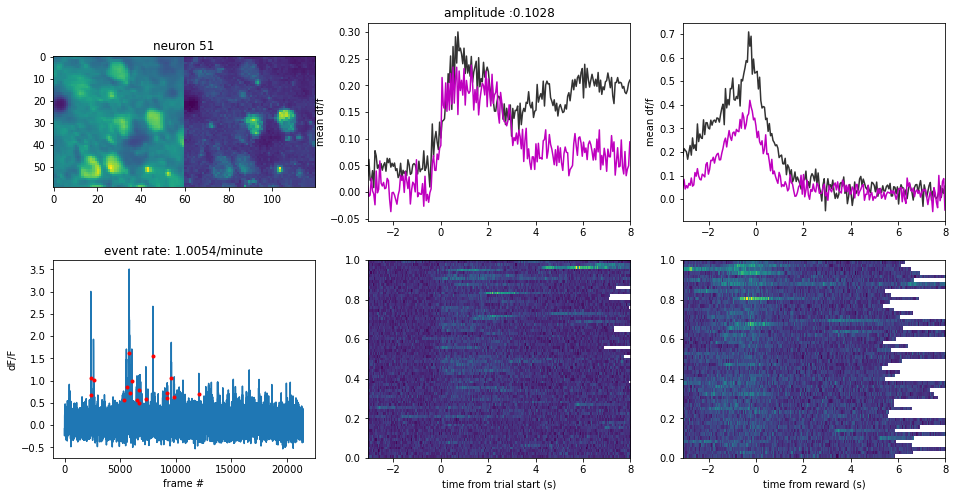

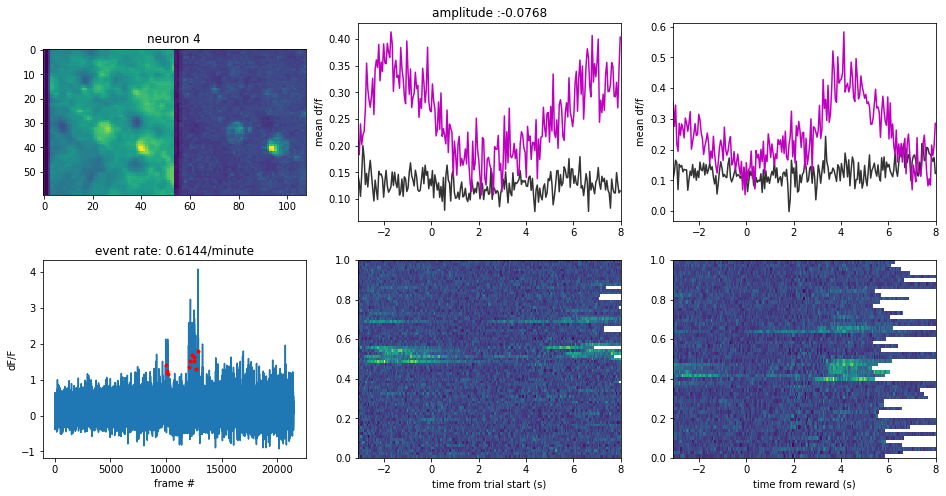

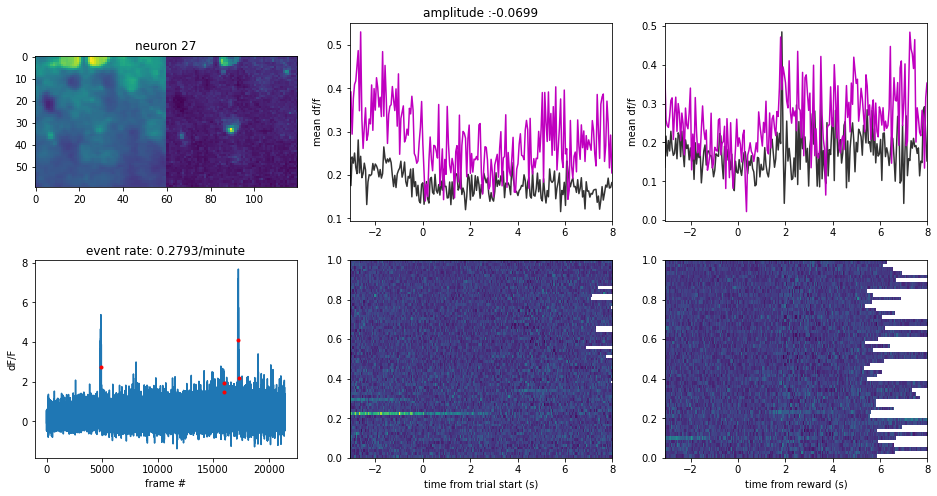

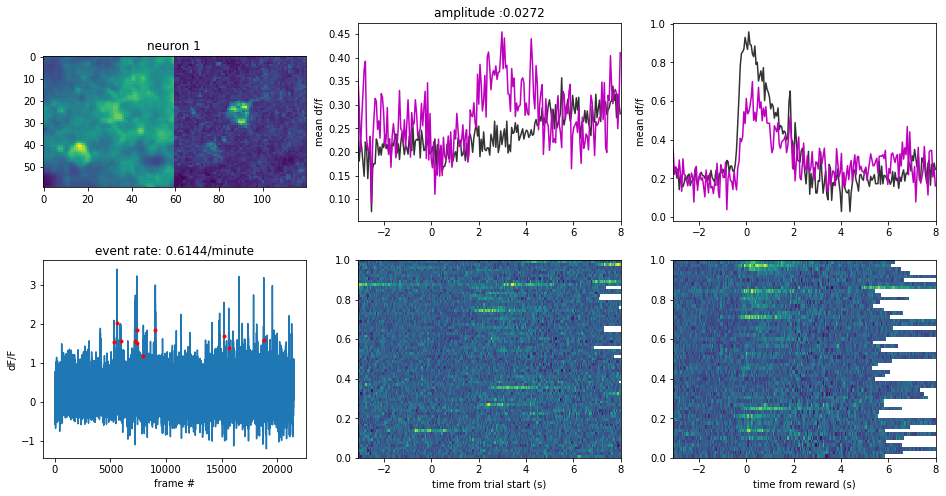

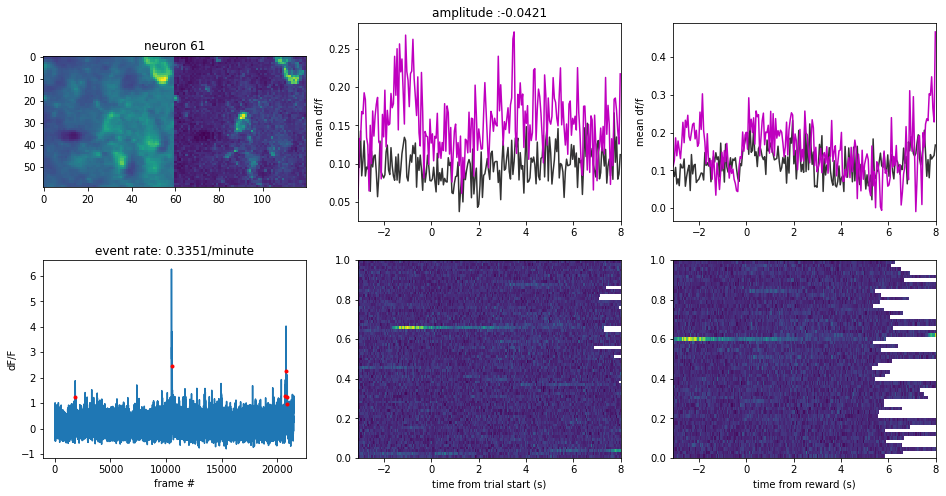

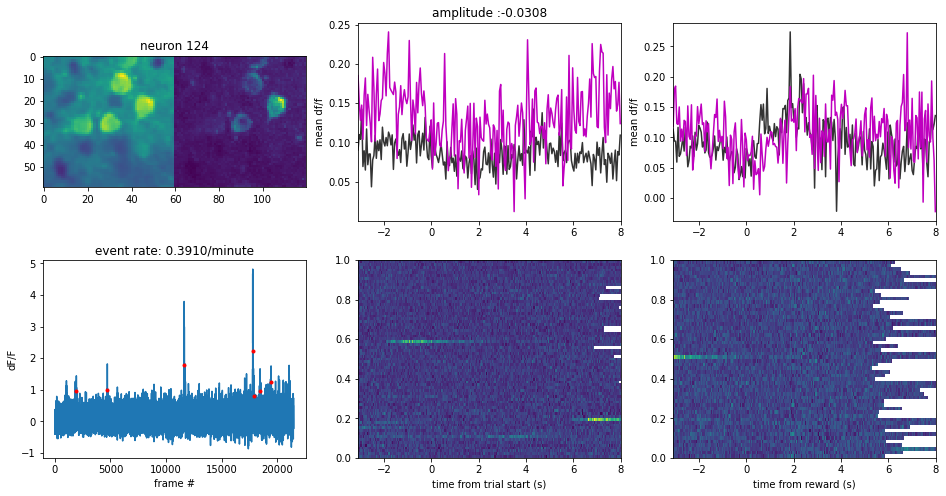

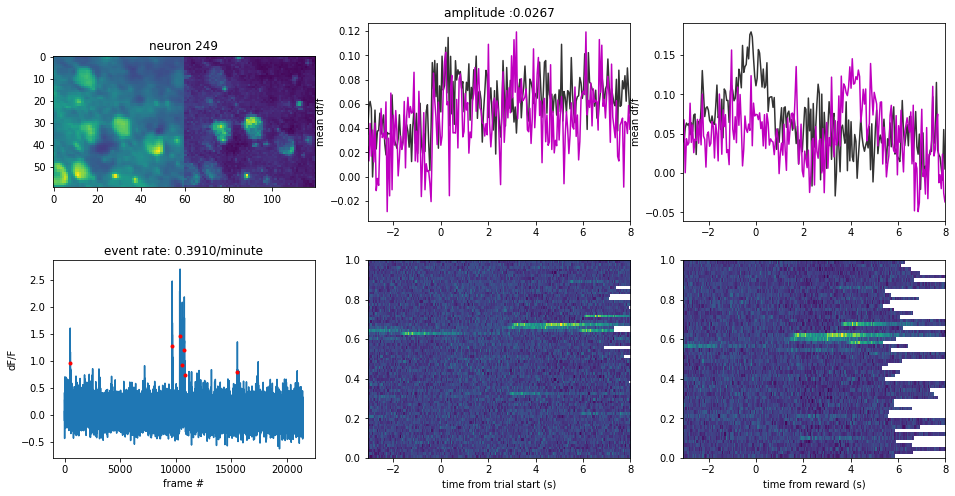

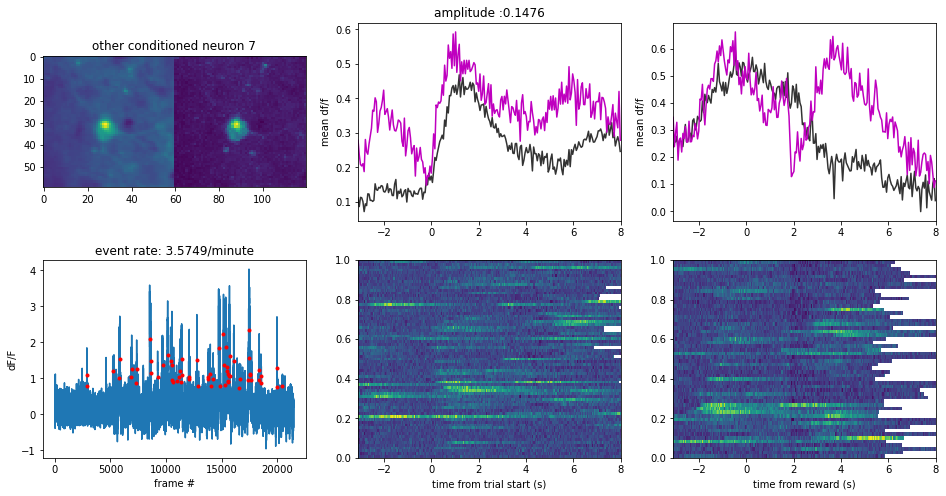

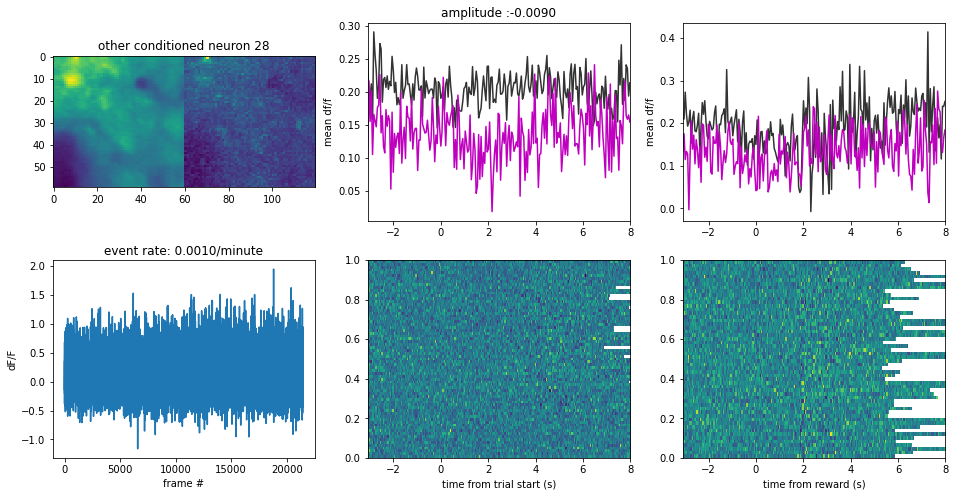

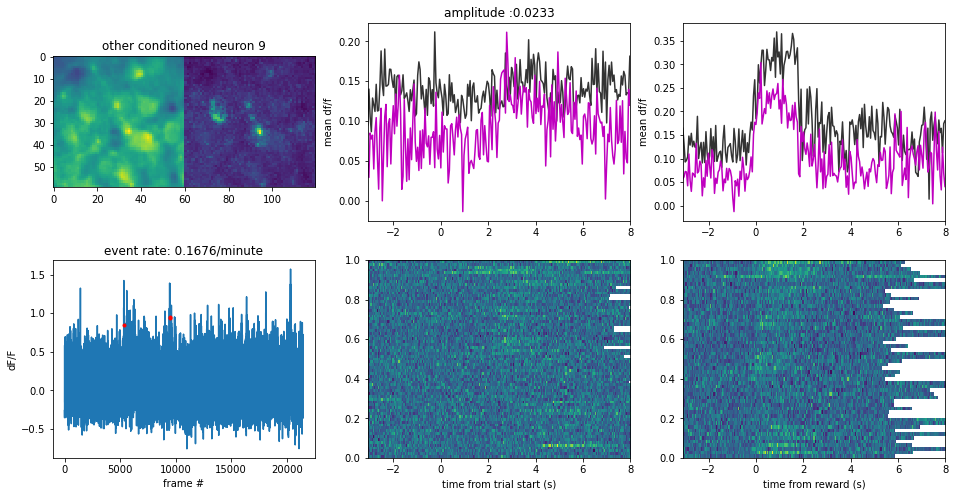

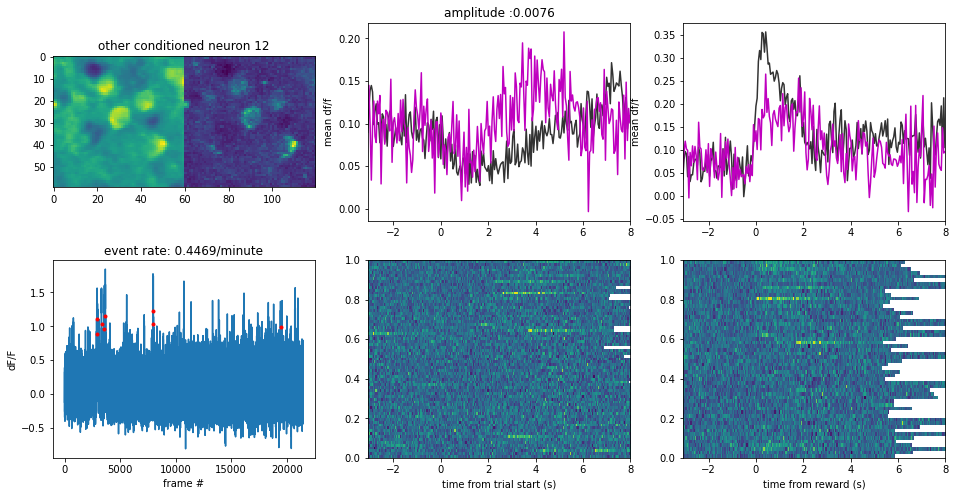

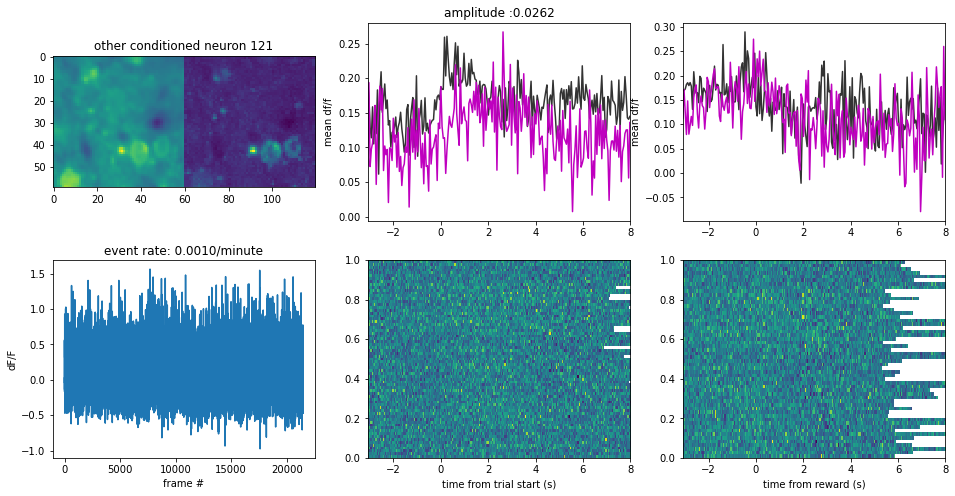

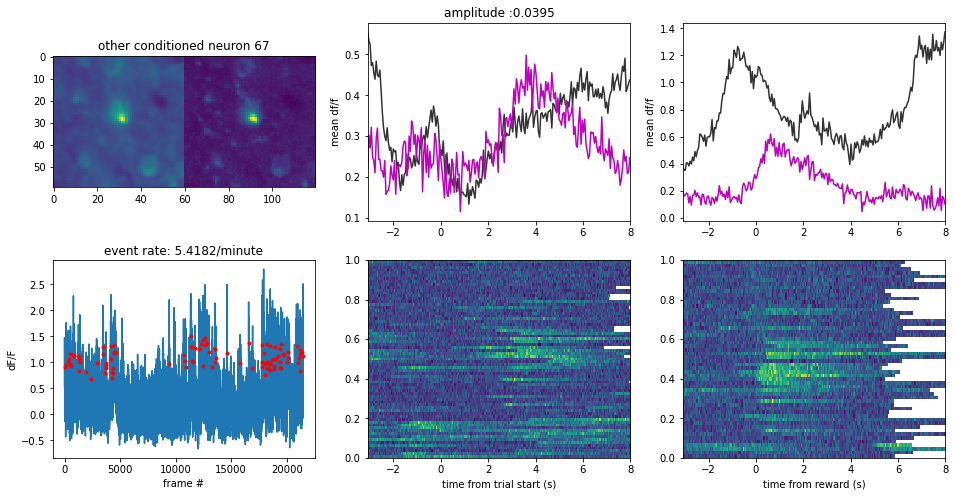

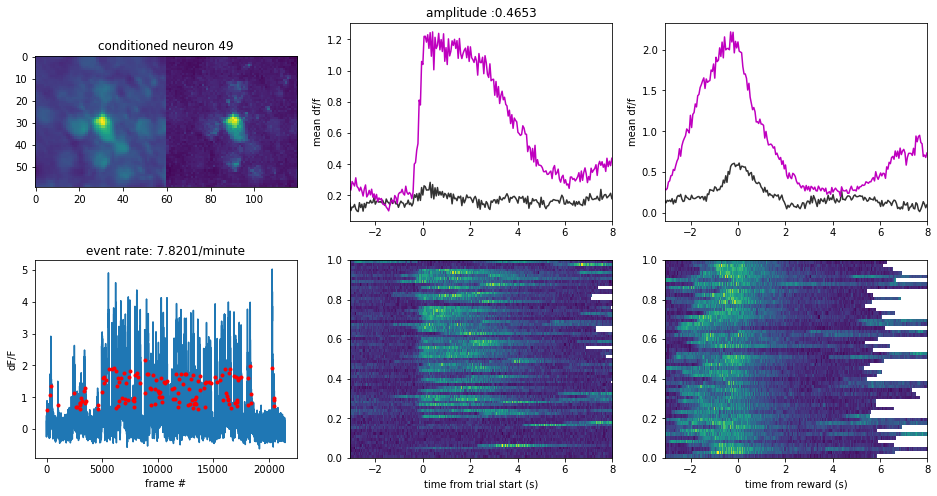

In [10]:
# plotting
# #cn_list = np.concatenate(cn_list)
# cn_list_ = []
# for cn_ in cn_list:
#     if type(cn_)==np.int64:
#         cn_list_.append(cn_)
# cn_list = cn_list_.copy()
from rastermap import Rastermap
save_pdf_copy_files = True
needed_neuron_num = 20
target_amplitude = np.nan
max_abs_amplitude = .2
minimum_pixel_num = 60 # 60 for 6s
min_event_rate = .5
target_amplitude_rate_percentile = 100#95
minimum_f0_percentile = 10
target_event_rate = 10

roi_pixel_range = 30 # display purposes
last_session = sessions[-1]
if len(sessions)>1:
    previous_session = sessions[-2]
else:
    previous_session = sessions[-1]
cn = np.median(np.asarray(data_dict[last_session]['cn'])[np.asarray(data_dict[last_session]['cn'])!=None])
try:
    if len(cn)>1:
        cn = np.nan
except:
    pass
if save_pdf_copy_files:
    Path(next_session_dir).mkdir(parents = True, exist_ok = True)
    pdf_obj = PdfPages(os.path.join(next_session_dir,'conditioned_neuron_suggestions.pdf'))
    
    
%matplotlib inline
    
fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111)
#events_zscore = zscore(data_dict[last_session]['events_clean'],1)
#events_zscore = zscore(data_dict[last_session]['dff_sessionwise'],1)
events_zscore = data_dict[last_session]['dff_sessionwise'].copy()
events_zscore[np.isnan(events_zscore)] = -3
events_zscore[np.isinf(events_zscore)] = -3

model = Rastermap(n_components=2, n_X=10, nPC=50, init='pca')
model.fit(events_zscore)


im_events = ax.imshow(events_zscore[model.isort,:],aspect = 'auto', interpolation = 'none')  
ax.set_ylabel('neurons')    
ax.set_xlabel('frames')    
#im_events.set_clim(np.percentile(data_dict[last_session]['dff_sessionwise'].flatten(),[5,90])) 
im_events.set_clim([-1,3])
ax.set_title('{} - {}'.format(subject,last_session))

if save_pdf_copy_files:
    pdf_obj.savefig(fig) 
    #break
#%
from scipy.stats import zscore
fig = plt.figure(figsize = [10,10])
ax_1 = fig.add_subplot(2,2,1)
ax_1.plot(data_dict[last_session]['event_rate'],data_dict[last_session]['amplitude_rate'],'k.',alpha = .3)
ax_1.set_yscale('log')
ax_1.set_xlabel('event rate')
ax_1.set_xscale('log')  
ax_1.set_ylabel('accumulated dF/F/s')
#%
ax_2 = fig.add_subplot(2,2,2,sharey = ax_1)
ax_2.plot( data_dict[last_session]['trial_averaged_amplitude'],data_dict[last_session]['amplitude_rate'],'k.',alpha = .3)
ax_2.set_yscale('log')
ax_2.set_ylabel('accumulated dF/F/s')
ax_2.set_xlabel('tuning to task')
ax_2.set_xlim([-2,2])
ax_3 = fig.add_subplot(2,2,3,sharex = ax_1)
ax_3.plot(data_dict[last_session]['event_rate'], data_dict[last_session]['trial_averaged_amplitude'],'k.',alpha = .3)
ax_3.set_xlabel('event rate')
ax_3.set_xscale('log') 
ax_3.set_ylabel('tuning to task')

ax_4 = fig.add_subplot(2,2,4)
ax_4.plot(data_dict[last_session]['f0_scalar'],data_dict[last_session]['amplitude_rate'],'k.',alpha = .3)
ax_4.set_xlabel('F0')
ax_4.set_yscale('log') 
ax_4.set_ylabel('accumulated dF/F/s')




target_amplitude_rate = np.percentile(data_dict[last_session]['amplitude_rate'],target_amplitude_rate_percentile)
amplitude_rate_log = np.log(data_dict[last_session]['amplitude_rate'])
event_rate_log = np.log(data_dict[last_session]['event_rate'])
event_rate_log

f0 = data_dict[last_session]['f0_scalar']
minimum_f0 = np.percentile(f0,minimum_f0_percentile)

amplitudes_zscore = (np.asarray( data_dict[last_session]['trial_averaged_amplitude'])-np.nanmedian( data_dict[last_session]['trial_averaged_amplitude']))/np.nanstd( data_dict[last_session]['trial_averaged_amplitude'])
amplitude_rate_zscore = (amplitude_rate_log-np.nanmedian(amplitude_rate_log))/np.nanstd(amplitude_rate_log)
event_rate_zscore = (event_rate_log-np.nanmedian(event_rate_log))/np.nanstd(event_rate_log)
f0_zscore = (f0-np.median(f0))/np.std(f0)
if np.isnan(target_amplitude):
    distances = np.sqrt((np.asarray(amplitude_rate_zscore)-(np.log(target_amplitude_rate)-np.nanmedian(amplitude_rate_log))/np.nanstd(amplitude_rate_log))**2 + 
                        (np.asarray(event_rate_zscore)-(np.log(target_event_rate)-np.nanmedian(event_rate_log))/np.nanstd(event_rate_log))**2)
                        #(np.asarray(f0_zscore)-(target_f0-np.nanmedian(f0))/np.nanstd(f0))**2)# + (amplitudes-target_amplitude)**2)
else:
    distances = np.sqrt((np.asarray(amplitudes_zscore)-(target_amplitude-np.nanmedian(amplitude))/np.nanstd(amplitude))**2 +
                        (np.asarray(amplitude_rate_zscore)-(np.log(target_amplitude_rate)-np.nanmedian(amplitude_rate_log))/np.nanstd(amplitude_rate_log))**2 + 
                        (np.asarray(event_rate_zscore)-(np.log(target_event_rate)-np.nanmedian(event_rate_log))/np.nanstd(event_rate_log))**2)
                        #(np.asarray(f0_zscore)-(target_f0-np.nanmedian(f0))/np.nanstd(f0))**2)# + (amplitudes-target_amplitude)**2)
distances[np.abs( data_dict[last_session]['trial_averaged_amplitude'])>max_abs_amplitude] += np.inf
#distances[data_dict[last_session]['event_rate']<min_event_rate] += np.inf
distances[data_dict[last_session]['f0_scalar']<minimum_f0] += np.inf
distances[pixel_num_list<minimum_pixel_num] += np.inf
potential_cn_list_ = list(np.argsort(distances))#[:needed_neuron_num]
potential_cn_list = []
while len(potential_cn_list)<needed_neuron_num:
    pot_cn_now = potential_cn_list_.pop(0)
    if pot_cn_now not in cn_list:
        potential_cn_list.append(pot_cn_now)
potential_cn_list = np.concatenate([potential_cn_list,cn_list])
potential_cn_list = np.asarray(potential_cn_list,int)
for idx in potential_cn_list:
    if idx == cn:
        color = 'mo'
    elif idx in cn_list:
        color = 'go'
    else:
        color = 'ro'
    ax_1.plot(data_dict[last_session]['event_rate'][idx],data_dict[last_session]['amplitude_rate'][idx],color,alpha = .5)
    ax_2.plot( data_dict[last_session]['trial_averaged_amplitude'][idx],data_dict[last_session]['amplitude_rate'][idx],color,alpha = .5)
    ax_3.plot(data_dict[last_session]['event_rate'][idx], data_dict[last_session]['trial_averaged_amplitude'][idx],color,alpha = .5)
    ax_4.plot(data_dict[last_session]['f0_scalar'][idx],data_dict[last_session]['amplitude_rate'][idx],color,alpha = .5)
if save_pdf_copy_files:
    pdf_obj.savefig(fig) 
#%

fig_meanimage = plt.figure(figsize = [10,10])
ax_mean_activity = fig_meanimage.add_subplot(2,1,1)
ax_mean_image_ = fig_meanimage.add_subplot(2,1,2)
ax_mean_image_.imshow(data_dict[last_session]['mean_image'], interpolation = 'none')
detectable_event_ratio = np.mean(data_dict[last_session]['signal_to_noise_trace']>minimum_d_prime,1)
order = np.argsort( data_dict[last_session]['trial_averaged_amplitude'])
im_mean_activity = ax_mean_activity.imshow(mean_activity_matrix_normalized[order,:],aspect= 'auto', interpolation = 'none',extent = [data_dict[last_session]['time_since_trial_start'][0],data_dict[last_session]['time_since_trial_start'][-1],mean_activity_matrix_normalized.shape[0]-.5,-.5])
ax_mean_activity.set_xlim([data_dict[last_session]['time_since_trial_start'][0],time_to_average_after_trial_start])
# =============================================================================
# ticks = np.arange(0,len(data_dict[last_session]['time_since_trial_start']),np.argmax(data_dict[last_session]['time_since_trial_start']>0)-1)#np.asarray(ax_mean_activity.get_xticks(),int)[1:-1]
# ax_mean_activity.set_xticks(ticks)
# ax_mean_activity.set_xticklabels(np.round(data_dict[last_session]['time_since_trial_start'][ticks],2))
# =============================================================================

im_mean_activity.set_clim(np.percentile(mean_activity_matrix_normalized.flatten(),[5,95]))
#%





for idx in potential_cn_list:#cn_list:#potential_cn_list:
    fig = plt.figure(figsize = [16,8])
    ax_mean_image = fig.add_subplot(2,3,1)
    ax_trial_average = fig.add_subplot(2,3,2)
    ax_whole_session = fig.add_subplot(2,3,4)
    ax_trial_locked_activity = fig.add_subplot(2,3,5,sharex = ax_trial_average)
    
    ax_reward_average = fig.add_subplot(2,3,3,sharex = ax_trial_average)
    ax_reward_locked_activity = fig.add_subplot(2,3,6,sharex = ax_trial_average)
    
    y= int(data_dict[last_session]['roiY'][idx])
    x= int(data_dict[last_session]['roiX'][idx])
    
    s = data_dict[last_session]['mean_image'].shape
    mean_image_cutout = data_dict[last_session]['mean_image'][np.max([0,y-roi_pixel_range]):np.min([s[0],roi_pixel_range+y]),
                                                              np.max([0,x- roi_pixel_range]):np.min([s[1],roi_pixel_range+x])]
    mean_image_cutout = mean_image_cutout/np.max(mean_image_cutout)
    max_image_cutout = data_dict[last_session]['max_image'][np.max([0,y-roi_pixel_range]):np.min([s[0],roi_pixel_range+y]),
                                                              np.max([0,x- roi_pixel_range]):np.min([s[1],roi_pixel_range+x])]
    max_image_cutout = max_image_cutout/np.max(max_image_cutout)
    ax_mean_image.imshow(np.concatenate([mean_image_cutout,max_image_cutout],1), interpolation = 'none')
    if idx == cn:
        color = 'mo'
        ax_mean_image.set_title('conditioned neuron {}'.format(idx))
    elif idx in cn_list:
        color = 'g.'
        ax_mean_image.set_title('other conditioned neuron {}'.format(idx))
    else:
        color = 'rx'
        ax_mean_image.set_title('neuron {}'.format(idx))
    ax_mean_image_.plot(data_dict[last_session]['roiX'][idx],data_dict[last_session]['roiY'][idx],color)
    ax_mean_image_.text(data_dict[last_session]['roiX'][idx],data_dict[last_session]['roiY'][idx], str(idx),color = 'white')
    ax_mean_activity.plot(0,order[idx],color)
    needed_frames_prev= data_dict[previous_session]['time_since_trial_start']<time_to_average_after_trial_start
    needed_frames= data_dict[last_session]['time_since_trial_start']<time_to_average_after_trial_start
    ax_trial_average.plot(data_dict[previous_session]['time_since_trial_start'][needed_frames_prev],data_dict[previous_session]['mean_activity_matrix'][idx,needed_frames_prev],'k-',alpha =.8)
    
    
    try:
        ax_trial_average.plot(data_dict[last_session]['time_since_trial_start'][needed_frames],data_dict[last_session]['mean_activity_matrix_previous_cn'][idx,needed_frames],'r-',alpha =.8)
    except:
        pass
    
    ax_trial_average.plot(data_dict[last_session]['time_since_trial_start'][needed_frames],data_dict[last_session]['mean_activity_matrix'][idx,needed_frames],'m-')
    
    ax_trial_locked_activity.set_xlabel('time from trial start (s)')
    ax_trial_average.set_ylabel('mean df/f')
    ax_trial_average.set_title('amplitude :{0:.4f}'.format( data_dict[last_session]['trial_averaged_amplitude'][idx]))
    ax_trial_average.set_xlim([data_dict[last_session]['time_since_trial_start'][0],time_to_average_after_trial_start])
    ax_trial_locked_activity.imshow(trialwise_dff_until_reward[:,idx,:].squeeze().T,aspect = 'auto', interpolation = 'none',extent = [data_dict[last_session]['time_since_trial_start'][0],data_dict[last_session]['time_since_trial_start'][-1],0,1])
    
    ax_reward_average.plot(data_dict[previous_session]['time_since_trial_start'][needed_frames_prev],data_dict[previous_session]['mean_reward_matrix'][idx,needed_frames_prev],'k-',alpha =.8)
    try:
        ax_reward_average.plot(data_dict[last_session]['time_since_trial_start'][needed_frames],data_dict[last_session]['mean_reward_matrix_previous_cn'][idx,needed_frames],'r-',alpha =.8)
    except:
        pass
    ax_reward_average.plot(data_dict[last_session]['time_since_trial_start'][needed_frames],mean_reward_matrix[idx,needed_frames],'m-')
    ax_reward_locked_activity.set_xlabel('time from reward (s)')
    ax_reward_average.set_ylabel('mean df/f')
    ax_reward_locked_activity.imshow(trialwise_reward_matrix[:,idx,:].squeeze().T,
                                     aspect = 'auto',
                                     extent = [data_dict[last_session]['time_since_trial_start'][0],data_dict[last_session]['time_since_trial_start'][-1],0,1],
                                     interpolation = 'none')
    ax_trial_average.set_xlim([data_dict[last_session]['time_since_trial_start'][0],time_to_average_after_trial_start])
    
# =============================================================================
#     xticks = ax_trial_locked_activity.get_xticks()
#     xticks = np.asarray(xticks[(xticks>0)&(xticks<len(data_dict[last_session]['time_since_trial_start']))],int)
#     ax_trial_locked_activity.set_xticks(xticks)
#     ax_trial_locked_activity.set_xticklabels(np.round(data_dict[last_session]['time_since_trial_start'][xticks],2))
# =============================================================================
    
    ax_whole_session.plot(data_dict[last_session]['dff_sessionwise'][idx,:])
    #%:30 a.m. to 5:30 p.m.
    for start_,end_ in  zip(np.where(np.diff(np.concatenate([[0],data_dict[last_session]['events_clean'][idx,:],[0]]))>0)[0],
                            np.where(np.diff(np.concatenate([[0],data_dict[last_session]['events_clean'][idx,:],[0]]))<0)[0]):
        center_idx = int(np.mean([start_,end_]))
        ax_whole_session.plot(center_idx,data_dict[last_session]['events_clean'][idx,center_idx],'r.')
                            
# =============================================================================
#     ax_whole_session.plot(np.where(data_dict[last_session]['events_clean'][idx,:]>0)[0],data_dict[last_session]['dff_sessionwise'][idx,data_dict[last_session]['events_clean'][idx,:]>0],'r.')
# =============================================================================
    ax_whole_session.set_xlabel('frame #')
    ax_whole_session.set_ylabel('dF/F')
    ax_whole_session.set_title('event rate: {0:.4f}/minute'.format(data_dict[last_session]['event_rate'][idx]))
    if save_pdf_copy_files:
        pdf_obj.savefig(fig) 
    #plt.close()
    #break
if save_pdf_copy_files:    
    pdf_obj.savefig(fig_meanimage) 
    pdf_obj.close()
    
    #% save selected roi indices
    mdict = mdict={'potential_cn_list': potential_cn_list.tolist(),
                   'meanImg': data_dict[last_session]['mean_image']}
    savemat(file_name=os.path.join(s2p_base_dir,subject, fov,'ops.mat'),
            mdict = mdict)
    # copy files over
    for file in file_list_to_copy_over:
        shutil.copyfile(os.path.join(s2p_base_dir,subject,fov,file),os.path.join(next_session_dir,file))

In [86]:
data_dict[last_session]['mean_activity_matrix'].shape

(492, 500)